# SIT 220 - Task 1.7HD: Data Mining Challenge

### Hoang Son Pham - Student ID: 223240555

## Introduction

This project analyzes the National Health and Nutrition Examination Survey (NHANES) dataset to uncover patterns related to diabetes risk factors and biomarkers. The NHANES program, conducted by the Centers for Disease Control and Prevention (CDC), provides a comprehensive assessment of health and nutritional status among the U.S. population through interviews, physical examinations, and laboratory tests. By merging different components of the NHANES dataset—demographic information, dietary intake, body measurements, blood pressure readings, and glycohemoglobin levels—this analysis aims to identify significant patterns and relationships that contribute to diabetes risk.

Diabetes represents a significant public health challenge, affecting millions of Americans and contributing to substantial healthcare costs and reduced quality of life. Understanding the complex interplay between demographic factors, dietary habits, physical measurements, and biomarkers is crucial for developing effective prevention and management strategies. This project employs a combination of data cleaning techniques, exploratory data analysis, visualization methods, and unsupervised machine learning algorithms to extract meaningful insights from this multidimensional health dataset.

Through this comprehensive analysis, we seek to identify key predictors of diabetes status, understand how different risk factors interact, and potentially uncover subgroups within the population with distinct risk profiles. The findings may contribute to more targeted screening approaches, personalized interventions, and improved public health strategies for addressing the growing diabetes epidemic.

## 0. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
import re
from sklearn.impute import SimpleImputer
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import row, column
from bokeh.models import Select, ColumnDataSource, HoverTool
from bokeh.models import ColorBar, LinearColorMapper, Label
from bokeh.palettes import Viridis256, Turbo256, Plasma256
from bokeh.models.layouts import Tabs, TabPanel
from bokeh.transform import linear_cmap
from bokeh.transform import transform
from bokeh.io import push_notebook
from bokeh.palettes import Category10
from bokeh.plotting import figure, show
from bokeh.transform import dodge

from ipywidgets import interact, widgets

from scipy.stats import gaussian_kde
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
import warnings
warnings.filterwarnings('ignore')
output_notebook()


Loading BokehJS ...

## 1. Quick look at the datasets

###  **Demographic**

Documentation:
https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DEMO_L.htm


In [2]:
demo = pd.read_sas("DEMO_L.xpt.txt", format="xport")
demo.head()

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  130378.0      12.0       2.0       1.0      43.0       NaN       5.0   
1  130379.0      12.0       2.0       1.0      66.0       NaN       3.0   
2  130380.0      12.0       2.0       2.0      44.0       NaN       2.0   
3  130381.0      12.0       2.0       2.0       5.0       NaN       5.0   
4  130382.0      12.0       2.0       1.0       2.0       NaN       3.0   

   RIDRETH3  RIDEXMON  RIDEXAGM  ...  DMDHRGND  DMDHRAGZ  DMDHREDZ  DMDHRMAZ  \
0       6.0       2.0       NaN  ...       NaN       NaN       NaN       NaN   
1       3.0       2.0       NaN  ...       NaN       NaN       NaN       NaN   
2       2.0       1.0       NaN  ...       NaN       NaN       NaN       NaN   
3       7.0       1.0      71.0  ...       2.0       2.0       2.0       3.0   
4       3.0       2.0      34.0  ...       2.0       2.0       3.0       1.0   

   DMDHSEDZ      WTINT2YR      WTMEC2YR  SDMVSTRA  SDMVPSU  INDFMPIR  
0       NaN  50055.450807  54374.463898     173.0      2.0      5.00  
1       NaN  29087.450605  34084.721548     173.0      2.0      5.00  
2       NaN  80062.674301  81196.277992     174.0      1.0      1.41  
3       NaN  38807.268902  55698.607106     182.0      2.0      1.53  
4       2.0  30607.519774  36434.146346     182.0      2.0      3.60  

[5 rows x 27 columns]

This demographics dataset includes details about survey participants, covering their interview and examination completion, along with associated sample weights and variance information. It also specifies the half-year period of the examination and the participant's pregnancy status. Furthermore, the file contains the ratio of family income to the poverty threshold, the total household size, and demographic characteristics of the household reference person. Additional demographic data provided includes gender, age, race/Hispanic origin, education level, marital status, military service status, birth country, and the number of years of U.S. residency.

### Check the shape of the dataset

In [3]:
demo.shape


(11933, 27)

### Column names

In [4]:
demo.columns


Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN',
       'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMDBORN4',
       'DMDYRUSR', 'DMDEDUC2', 'DMDMARTZ', 'RIDEXPRG', 'DMDHHSIZ', 'DMDHRGND',
       'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ', 'DMDHSEDZ', 'WTINT2YR', 'WTMEC2YR',
       'SDMVSTRA', 'SDMVPSU', 'INDFMPIR'],
      dtype='object')

### Number of missing values in each column

In [5]:
demo.isnull().sum()

SEQN            0
SDDSRVYR        0
RIDSTATR        0
RIAGENDR        0
RIDAGEYR        0
RIDAGEMN    11556
RIDRETH1        0
RIDRETH3        0
RIDEXMON     3073
RIDEXAGM     9146
DMQMILIZ     3632
DMDBORN4       19
DMDYRUSR    10058
DMDEDUC2     4139
DMDMARTZ     4141
RIDEXPRG    10430
DMDHHSIZ        0
DMDHRGND     7818
DMDHRAGZ     7809
DMDHREDZ     8187
DMDHRMAZ     7913
DMDHSEDZ     9806
WTINT2YR        0
WTMEC2YR        0
SDMVSTRA        0
SDMVPSU         0
INDFMPIR     2041
dtype: int64

There are columns with a lot of missing values so we need to handle them gracefully so that we would not lose too much valuable information

### Drop missing values

We will identify columns with the number of missing values greater than 30% of the total instances in that columns and then drop them. With this large proportion of missing values, any imputation method would introduce a lot of bias to the whole dataset

In [6]:
drop_cols = demo.columns[demo.isnull().mean() > 0.3]
drop_cols

Index(['RIDAGEMN', 'RIDEXAGM', 'DMQMILIZ', 'DMDYRUSR', 'DMDEDUC2', 'DMDMARTZ',
       'RIDEXPRG', 'DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ', 'DMDHSEDZ'],
      dtype='object')

In [7]:
demo = demo.drop(columns=drop_cols)


### Rename columns

There are a lot of columns in this dataset but their names are written in abbreviation so we may need to rename the columns for better understanding and analysis

In [8]:
demo  = demo.rename(columns={'SDDSRVYR':'ReleaseCycle','RIDSTATR':'InterviewStatus','RIAGENDR':'Gender', 'RIDAGEYR':'AgeInYear','RIDRETH1':'Race','RIDRETH3':'RaceWithNHAsian',
                     'RIDEXMON':'6MonthPeriod','DMDBORN4':'CountryOfBirth','DMDHHSIZ':'PeopleInHousehold','WTINT2YR':'InterviewWeight','WTMEC2YR':'ExamWeight','SDMVSTRA':'VariancePseudostratum',
                     'SDMVPSU':'VariancePseudoPSU','INDFMPIR':'FamilyIncomeToPoverty'}
)
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SEQN                   11933 non-null  float64
 1   ReleaseCycle           11933 non-null  float64
 2   InterviewStatus        11933 non-null  float64
 3   Gender                 11933 non-null  float64
 4   AgeInYear              11933 non-null  float64
 5   Race                   11933 non-null  float64
 6   RaceWithNHAsian        11933 non-null  float64
 7   6MonthPeriod           8860 non-null   float64
 8   CountryOfBirth         11914 non-null  float64
 9   PeopleInHousehold      11933 non-null  float64
 10  InterviewWeight        11933 non-null  float64
 11  ExamWeight             11933 non-null  float64
 12  VariancePseudostratum  11933 non-null  float64
 13  VariancePseudoPSU      11933 non-null  float64
 14  FamilyIncomeToPoverty  9892 non-null   float64
dtypes:

### Create categorical features mapping

Current categorical columns are having data encoded. We create a dictionary including all categorical features and their coresponding value mapping.

In [9]:


discrete_mappings = {
    'InterviewStatus':{
        1 : "Interview only",
        2 : "Both Interview and MEC"
    },
    'Gender': {
        1: "Male",
        2: "Female",
        
    },
    'Race':{
        1: "Mexican American",
        2: "Other Hispanic",
        3: "Non-Hispanic White",
        4: "Non-Hispanic Black",
        5: "Other Race"
    },
    'RaceWithNHAsian':{
        1: "Mexican American",
        2: "Other Hispanic",
        3: "Non-Hispanic White",
        4: "Non-Hispanic Black",
        6: "Non-Hispanic Asian",
        7: "Other Race",
        
    },
    '6MonthPeriod':{
        1: "Nov 1 - April 30",
        2: "May 1 - Oct 31"
    },
    'CountryOfBirth':{
        1: "US",
        2: "Others",
        77: "Refused",
        99: "Do not know"
    }
}


###  **Dietary Intake**

Documentation: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/DR1TOT_L.htm

The Dietary Intake dataset (DR1TOT_L) contains comprehensive nutritional information collected through 24-hour dietary recall interviews. This rich dataset captures the consumption of over 60 nutrients and dietary components including macronutrients (proteins, carbohydrates, fats), micronutrients (vitamins, minerals), and specific fatty acid profiles.

In [10]:
diet = pd.read_sas("DR1TOT_L.xpt.txt", format="xport")
diet.head()

SEQN        WTDRD1         WTDR2D  DR1DRSTZ  DR1EXMER  DRABF  DRDINT  \
0  130378.0  61366.555827   70554.222162       1.0      73.0    2.0     2.0   
1  130379.0  34638.056480   36505.468348       1.0      73.0    2.0     2.0   
2  130380.0  84728.261560  103979.190677       1.0      73.0    2.0     2.0   
3  130381.0  61737.133446   75009.220819       1.0      91.0    2.0     2.0   
4  130382.0  75846.746917  172361.851828       1.0      73.0    2.0     2.0   

   DR1DBIH  DR1DAY  DR1LANG  ...  DRD370QQ  DRD370R  DRD370RQ  DRD370S  \
0     40.0     4.0      1.0  ...       NaN      2.0       NaN      2.0   
1     19.0     4.0      1.0  ...       1.0      2.0       NaN      2.0   
2     16.0     4.0      1.0  ...       NaN      2.0       NaN      2.0   
3     23.0     5.0      1.0  ...       NaN      2.0       NaN      2.0   
4     27.0     6.0      1.0  ...       NaN      2.0       NaN      2.0   

   DRD370SQ  DRD370T  DRD370TQ  DRD370U  DRD370UQ  DRD370V  
0       NaN      2.0       NaN      2.0       NaN      2.0  
1       NaN      2.0       NaN      2.0       NaN      2.0  
2       NaN      1.0       4.0      2.0       NaN      2.0  
3       NaN      2.0       NaN      2.0       NaN      2.0  
4       NaN      2.0       NaN      2.0       NaN      2.0  

[5 rows x 168 columns]

In [11]:
diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8860 entries, 0 to 8859
Columns: 168 entries, SEQN to DRD370V
dtypes: float64(168)
memory usage: 11.4 MB


### Drop the missing values

We also drop the columns with the number of missing values is greater than 30% of total instances

In [12]:
drop_cols = diet.columns[diet.isnull().mean() > 0.3]
drop_cols

Index(['DBD100', 'DR1SKY', 'DRQSDT1', 'DRQSDT2', 'DRQSDT3', 'DRQSDT4',
       'DRQSDT5', 'DRQSDT6', 'DRQSDT7', 'DRQSDT8', 'DRQSDT9', 'DRQSDT10',
       'DRQSDT11', 'DRQSDT12', 'DRQSDT91', 'DRD350A', 'DRD350AQ', 'DRD350B',
       'DRD350BQ', 'DRD350C', 'DRD350CQ', 'DRD350D', 'DRD350DQ', 'DRD350E',
       'DRD350EQ', 'DRD350F', 'DRD350FQ', 'DRD350G', 'DRD350GQ', 'DRD350H',
       'DRD350HQ', 'DRD350I', 'DRD350IQ', 'DRD350J', 'DRD350JQ', 'DRD350K',
       'DRD370A', 'DRD370AQ', 'DRD370B', 'DRD370BQ', 'DRD370C', 'DRD370CQ',
       'DRD370D', 'DRD370DQ', 'DRD370E', 'DRD370EQ', 'DRD370F', 'DRD370FQ',
       'DRD370G', 'DRD370GQ', 'DRD370H', 'DRD370HQ', 'DRD370I', 'DRD370IQ',
       'DRD370J', 'DRD370JQ', 'DRD370K', 'DRD370KQ', 'DRD370L', 'DRD370LQ',
       'DRD370M', 'DRD370MQ', 'DRD370N', 'DRD370NQ', 'DRD370O', 'DRD370OQ',
       'DRD370P', 'DRD370PQ', 'DRD370Q', 'DRD370QQ', 'DRD370R', 'DRD370RQ',
       'DRD370S', 'DRD370SQ', 'DRD370T', 'DRD370TQ', 'DRD370U', 'DRD370UQ',
       'DRD370V'],

In [13]:
diet = diet.drop(columns=drop_cols)


### Rename the columns

In [14]:
diet = diet.rename(columns={'WTDRD1':'D1Weight','WTDR2D':'D2Weight','DR1DRSTZ':'RecallStatus','DR1EXMER':'InterviewerID','DRABF':'BreastfedInfant','DRDINT':'IntakeDays','DR1DBIH':'DaysBetween','DR1DAY':'IntakeWeekDay','DR1LANG':'RespondLang','DR1MRESP':'MainRespondent',
                            'DR1HELP':'RepondHelper','DBQ095Z':'SaltType','DRQSPREP':'SaltPrepare','DR1STY':'SaltYesterday','DRQSDIET':'OnDiet','DR1TNUMF':'FoodNumber','DR1TKCAL':'Energy','DR1TPROT':'Protein','DR1TCARB':'Carbohydrate','DR1TSUGR':'Sugar',
                            'DR1TFIBE':'DietFiber','DR1TTFAT':'Fat','DR1TSFAT':'SatFatAcid','DR1TMFAT':'MonosatFatAcid','DR1TPFAT':'PolyunsatFatAcid','DR1TCHOL':'Cholesterol','DR1TATOC':'VitaminE', 'DR1TATOA':'AddedVitaminE','DR1TRET':'Retinol','DR1TVARA':'VitaminA',
                            'DR1TACAR':'AlphaCarotene','DR1TBCAR':'BetaCarotene','DR1TCRYP':'BetaCryptoxanthin','DR1TLYCO':'Lycopene','DR1TLZ':'LuteinZeaxanthin','DR1TVB1':'Thiamin','DR1TVB2':'Riboflavin','DR1TNIAC':'Niacin','DR1TVB6':'VitaminB6','DR1TFOLA':'TotalFolate',
                            'DR1TFA':' FolicAcid','DR1TFF':'FoodFolate','DR1TFDFE':'FolateDFE','DR1TCHL':'TotalCholine','DR1TVB12':'VitaminB12','DR1TB12A':'AddedVitaminB12','DR1TVC':'VitaminC','DR1TVD':'VitaminD','DR1TVK':'VitaminK','DR1TCALC':'Calcium',
                            'DR1TPHOS':'Phosphorus','DR1TMAGN':'Magnesium','DR1TIRON':'Iron','DR1TZINC':'Zinc','DR1TCOPP':'Copper','DR1TSODI':'Sodium','DR1TPOTA':'Potassium','DR1TSELE':'Selenium','DR1TCAFF':'Caffeine','DR1TTHEO':'Theobromine',
                            'DR1TALCO':'Alcohol','DR1TMOIS':'Moisture','DR1TS040':'Butanoic','DR1TS060':'Hexanoic','DR1TS080':'Octanoic','DR1TS100':'Decanoic','DR1TS120':'Dodecanoic','DR1TS140':'Tetradecanoic','DR1TS160':'Hexadecanoic','DR1TS180':'Octadecanoic',
                            'DR1TM161':'Hexadecenoic','DR1TM181':'Octadecenoic','DR1TM201':'Eicosenoic','DR1TM221':'Docosenoic','DR1TP182':'Octadecadienoic','DR1TP183':'Octadecatrienoic','DR1TP184':'Octadecatetraenoic','DR1TP204':'Eicosatetraenoic','DR1TP205':'Eicosapentaenoic','DR1TP225':'Docosapentaenoic',
                            'DR1TP226':'Docosahexaenoic','DR1_300':'FoodYesterdayUsual','DR1_320Z':'PlainWaterYesterday','DR1_330Z':'TapWaterYesterday','DR1BWATZ':'BottledWaterYesterday','DR1TWSZ':'TapWaterSource','DRD340':'Shellfish30','DRD360':'Fish30'
                            })
diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8860 entries, 0 to 8859
Data columns (total 89 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SEQN                   8860 non-null   float64
 1   D1Weight               8860 non-null   float64
 2   D2Weight               6754 non-null   float64
 3   RecallStatus           8860 non-null   float64
 4   InterviewerID          6797 non-null   float64
 5   BreastfedInfant        6734 non-null   float64
 6   IntakeDays             6754 non-null   float64
 7   DaysBetween            6375 non-null   float64
 8   IntakeWeekDay          6797 non-null   float64
 9   RespondLang            6802 non-null   float64
 10  MainRespondent         6747 non-null   float64
 11  RepondHelper           6747 non-null   float64
 12  SaltType               6797 non-null   float64
 13  SaltPrepare            6797 non-null   float64
 14  SaltYesterday          6797 non-null   float64
 15  OnDi

### Identify the categorical columns and add to the dictionary

In [15]:
discrete_mappings.update({
    'RecallStatus': {
        1: "Reliable",
        2: "Not reliable",
        4: "Consume breast-milk",
        5: "Not done"
    },
    'BreastfedInfant': {
        1: "Yes",
        2: "No",
    },
    'IntakeDays':{
        1: "Day 1",
        2: "Day 1 and 2"
    },
    'IntakeWeekDay':{
        1: "Sunday",
        2: "Monday",
        3: "Tuesday",
        4: "Wednesday",
        5: "Thursday",
        6: "Friday",
        7: "Saturday"
    },
    'RespondLang':{
        1: "English",
        2: "Spanish",
        3: "Both Eng and Span",
        4: "Other"
    },
    'MainRespondent':{
        1: "SP",
        2: "Mother of SP",
        3: "Father of SP",
        5: "Spouse of SP",
        6: "Child of SP",
        7: "Grandparent of SP",
        8: "Friend, partner, non-relative",
        9: "Translator, not a HH member",
        10: "Child care provider, caretaker",
        11: "Other relative",
        77: "Refused",
        99: "Don't know"
    },
    'RepondHelper':{
        1: "SP",
        4: "Parent of SP",
        5: "Spouse of SP",
        6: "Child of SP",
        7: "Grandparent of SP",
        8: "Friend, partner, non-relative",
        9: "Translator, not a HH member",
        10: "Child care provider, caretaker",
        11: "Other relative",
        12: "No one",
        77: "Refused",
        99: "Don't know"
    },
    'SaltType':{
        1: "Ordinary salt",
        2: "Lite salt",
        3: "Salt substitute",
        4: "Not use",
        91: "Other",
        99: "Don't know"
    },
    'SaltPrepare':{
        1: "Never",
        2: "Rarely",
        3: "Occasionally",
        4: "Very often",
        9: "Don't know"
    },
    'SaltYesterday':{
        1: "Yes",
        2: "No",
        9: "Don't know"
    },
    'OnDiet':{
        1: "Yes",
        2: "No",
        9: "Don't know"
    },
    'FoodYesterdayUsual':{
        1: "More than usual",
        2: "Usual",
        3: "Much less than usual",
        7: "Refused",
        9: "Don't know"
    },
    'TapWaterSource':{
        1: "Community supply",
        4: "Don't drink tap water",
        91: "Other",
        99: "Don't know"
    },
    'Shellfish30':{
        1: "Yes",
        2: "No",
        7: "Refused",
        9: "Don't know"
    },
    'Fish30': {
        1: "Yes",
        2: "No",
        7: "Refused",
        9: "Don't know"
    }
    
})

### **Body Measures**

Documentation: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BMX_L.htm

The Body Measures dataset (BMX_L) contains anthropometric measurements collected by trained health technicians during the physical examination component of NHANES. Key variables include weight, standing height, BMI, waist circumference, and various body segment measurements. 

In [16]:
body = pd.read_sas("BMX_L.xpt.txt", format = "xport")
body.head()

SEQN  BMDSTATS  BMXWT  BMIWT  BMXRECUM  BMIRECUM  BMXHEAD  BMIHEAD  \
0  130378.0       1.0   86.9    NaN       NaN       NaN      NaN      NaN   
1  130379.0       1.0  101.8    NaN       NaN       NaN      NaN      NaN   
2  130380.0       1.0   69.4    NaN       NaN       NaN      NaN      NaN   
3  130381.0       1.0   34.3    NaN       NaN       NaN      NaN      NaN   
4  130382.0       3.0   13.6    NaN       NaN       1.0      NaN      NaN   

   BMXHT  BMIHT  ...  BMXLEG  BMILEG  BMXARML  BMIARML  BMXARMC  BMIARMC  \
0  179.5    NaN  ...    42.8     NaN     42.0      NaN     35.7      NaN   
1  174.2    NaN  ...    38.5     NaN     38.7      NaN     33.7      NaN   
2  152.9    NaN  ...    38.5     NaN     35.5      NaN     36.3      NaN   
3  120.1    NaN  ...     NaN     NaN     25.4      NaN     23.4      NaN   
4    NaN    1.0  ...     NaN     NaN      NaN      1.0      NaN      1.0   

   BMXWAIST  BMIWAIST  BMXHIP  BMIHIP  
0      98.3       NaN   102.9     NaN  
1     114.7       NaN   112.4     NaN  
2      93.5       NaN    98.0     NaN  
3      70.4       NaN     NaN     NaN  
4       NaN       1.0     NaN     NaN  

[5 rows x 22 columns]

### Drop the missing values

In [17]:
drop_cols = body.columns[body.isnull().mean() > 0.3]
drop_cols

Index(['BMIWT', 'BMXRECUM', 'BMIRECUM', 'BMXHEAD', 'BMIHEAD', 'BMIHT',
       'BMDBMIC', 'BMILEG', 'BMIARML', 'BMIARMC', 'BMIWAIST', 'BMIHIP'],
      dtype='object')

In [18]:
body = body.drop(columns=drop_cols)
body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8860 entries, 0 to 8859
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      8860 non-null   float64
 1   BMDSTATS  8860 non-null   float64
 2   BMXWT     8754 non-null   float64
 3   BMXHT     8499 non-null   float64
 4   BMXBMI    8471 non-null   float64
 5   BMXLEG    7335 non-null   float64
 6   BMXARML   8568 non-null   float64
 7   BMXARMC   8562 non-null   float64
 8   BMXWAIST  8190 non-null   float64
 9   BMXHIP    6776 non-null   float64
dtypes: float64(10)
memory usage: 692.3 KB


### Rename the columns

In [19]:
body = body.rename(columns={'BMDSTATS':'StatusCode','BMXWT':'Weight','BMXHT':'StandingHeight','BMXBMI':'BMI','BMXLEG':'UpperLegLength','BMXARML':'UpperArmLength',
                            'BMXARMC':'ArmCircumference','BMXWAIST':'WaistCircumference','BMXHIP':'Hip Circumference'})
body.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8860 entries, 0 to 8859
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SEQN                8860 non-null   float64
 1   StatusCode          8860 non-null   float64
 2   Weight              8754 non-null   float64
 3   StandingHeight      8499 non-null   float64
 4   BMI                 8471 non-null   float64
 5   UpperLegLength      7335 non-null   float64
 6   UpperArmLength      8568 non-null   float64
 7   ArmCircumference    8562 non-null   float64
 8   WaistCircumference  8190 non-null   float64
 9   Hip Circumference   6776 non-null   float64
dtypes: float64(10)
memory usage: 692.3 KB


### Identify the categorical column in the dataset

In [20]:
discrete_mappings.update({
    'StatusCode': {
        1: "Complete",
        2: "Only height and weight",
        3: "Other partial exam",
        4: "No body measures exam data"
    },
})

### **Blood Pressure and Oscillometric Measurements**

Documentation: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/BPXO_L.htm

The Blood Pressure dataset (BPXO_L) contains oscillometric blood pressure readings taken by trained technicians following standardized protocols. For each participant, three consecutive blood pressure measurements were recorded after a resting period, providing systolic pressure, diastolic pressure, and pulse rate for each reading.

In [21]:
bp = pd.read_sas("BPXO_L.xpt.txt", format = "xport")
bp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7801 entries, 0 to 7800
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      7801 non-null   float64
 1   BPAOARM   7801 non-null   object 
 2   BPAOCSZ   7611 non-null   float64
 3   BPXOSY1   7517 non-null   float64
 4   BPXODI1   7517 non-null   float64
 5   BPXOSY2   7505 non-null   float64
 6   BPXODI2   7505 non-null   float64
 7   BPXOSY3   7480 non-null   float64
 8   BPXODI3   7480 non-null   float64
 9   BPXOPLS1  7517 non-null   float64
 10  BPXOPLS2  7505 non-null   float64
 11  BPXOPLS3  7480 non-null   float64
dtypes: float64(11), object(1)
memory usage: 731.5+ KB


### Drop missing values

In [22]:
drop_cols = bp.columns[bp.isnull().mean() > 0.3]
drop_cols

Index([], dtype='object')

The number of missing values in this dataset is quite mild

### Rename the columns

In [23]:
bp = bp.rename(columns = {'BPAOARM':'ArmOscillometric','BPAOCSZ':'CodedCuffSize','BPXOSY1':'Systolic1','BPXODI1':'Diastolic1', 'BPXOSY2':'Systolic2',
                          'BPXODI2':'Diastolic2','BPXOSY3':'Systolic3','BPXODI3':'Diastolic3','BPXOPLS1':'Pulse1','BPXOPLS2':'Pulse2','BPXOPLS3':'Pulse3'
                          })
bp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7801 entries, 0 to 7800
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SEQN              7801 non-null   float64
 1   ArmOscillometric  7801 non-null   object 
 2   CodedCuffSize     7611 non-null   float64
 3   Systolic1         7517 non-null   float64
 4   Diastolic1        7517 non-null   float64
 5   Systolic2         7505 non-null   float64
 6   Diastolic2        7505 non-null   float64
 7   Systolic3         7480 non-null   float64
 8   Diastolic3        7480 non-null   float64
 9   Pulse1            7517 non-null   float64
 10  Pulse2            7505 non-null   float64
 11  Pulse3            7480 non-null   float64
dtypes: float64(11), object(1)
memory usage: 731.5+ KB


### Identify the categorical feature

In [24]:
discrete_mappings.update( {
    'ArmOscillometric': {
        b'L': "Left",
        b'R': "Right"
        
    },
    'CodedCuffSize':{
        2: "17 - 21.9",
        3: "22 - 31.9",
        4: "32-41.9",
        5: "42-50"
    }
})

### **Glycohemoglobin**

Documentation: https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2021/DataFiles/GHB_L.htm

The Glycohemoglobin dataset (GHB_L) contains laboratory results for glycated hemoglobin (HbA1c) measured from blood samples. This critical biomarker reflects average blood glucose levels over the previous 2-3 months and serves as the primary indicator for diabetes diagnosis and management in our analysis. 

In [25]:
gly = pd.read_sas("GHB_L.xpt.txt", format="xport")
gly.head()

SEQN       WTPH2YR  LBXGH
0  130378.0  56042.129410    5.6
1  130379.0  37435.705647    5.6
2  130380.0  85328.844519    6.2
3  130386.0  44526.214135    5.1
4  130387.0  22746.296353    5.9

In [26]:
gly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7199 entries, 0 to 7198
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SEQN     7199 non-null   float64
 1   WTPH2YR  7199 non-null   float64
 2   LBXGH    6715 non-null   float64
dtypes: float64(3)
memory usage: 168.9 KB


### Rename the columns

In [27]:
gly = gly.rename(columns={'WTPH2YR':'PhlebotomyWeight','LBXGH':'Glycohemoglobin'})
gly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7199 entries, 0 to 7198
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SEQN              7199 non-null   float64
 1   PhlebotomyWeight  7199 non-null   float64
 2   Glycohemoglobin   6715 non-null   float64
dtypes: float64(3)
memory usage: 168.9 KB


## 2. Merge the datasets

We will merge the datasets based on the 'SEQN' column which is the sequence number of each patient and print out the shape of the final dataset.  
Reasons for using inner join:
- Complete case analysis: The analysis focused on diabetes risk factors requiring all key measurements (glycohemoglobin, body measurements, blood pressure). An inner join ensures we only analyze participants with complete data across all domains.
- Primary outcome availability: Since glycohemoglobin was our primary outcome variable, only participants with this measurement were relevant to the analysis.
- Avoiding sparse data interpretation: Left joins would preserve records missing critical measurements, complicating cluster analysis and potentially leading to misleading patterns.
- Adequate sample size: After inner joining, we still retained 7,200+ observations, providing sufficient statistical power while ensuring completeness of key variables.
- Focus on multivariate patterns: The analysis aimed to discover relationships between variables across all datasets (demographic, dietary, body measurements, and biomarkers), requiring participants to have data in all these domains.

In [28]:
merged_df = demo.merge(diet, on='SEQN', how='inner')
merged_df = merged_df.merge(body, on='SEQN', how='inner')
merged_df = merged_df.merge(bp, on='SEQN', how='inner') 
merged_df = merged_df.merge(gly, on='SEQN', how='inner')

# Check the shape of the merged dataset
print("Original shapes:")
print(f"Demo: {demo.shape}")
print(f"Diet: {diet.shape}")
print(f"Body: {body.shape}")
print(f"BP: {bp.shape}")
print(f"Glycohemoglobin: {gly.shape}")
print(f"Merged: {merged_df.shape}")

# Check for any duplicate columns that might have been created
duplicate_cols = merged_df.columns[merged_df.columns.duplicated()]
if len(duplicate_cols) > 0:
    print("Duplicate columns found:", duplicate_cols.tolist())

# Show the first few rows of the merged dataset
merged_df.head()

Original shapes:
Demo: (11933, 15)
Diet: (8860, 89)
Body: (8860, 10)
BP: (7801, 12)
Glycohemoglobin: (7199, 3)
Merged: (7199, 125)


SEQN  ReleaseCycle  InterviewStatus  Gender  AgeInYear  Race  \
0  130378.0          12.0              2.0     1.0       43.0   5.0   
1  130379.0          12.0              2.0     1.0       66.0   3.0   
2  130380.0          12.0              2.0     2.0       44.0   2.0   
3  130386.0          12.0              2.0     1.0       34.0   1.0   
4  130387.0          12.0              2.0     2.0       68.0   3.0   

   RaceWithNHAsian  6MonthPeriod  CountryOfBirth  PeopleInHousehold  ...  \
0              6.0           2.0             2.0                4.0  ...   
1              3.0           2.0             1.0                2.0  ...   
2              2.0           1.0             2.0                7.0  ...   
3              1.0           1.0             1.0                3.0  ...   
4              3.0           2.0             1.0                1.0  ...   

   Diastolic1  Systolic2  Diastolic2  Systolic3  Diastolic3  Pulse1  Pulse2  \
0        98.0      131.0        96.0      132.0        94.0    82.0    79.0   
1        84.0      117.0        76.0      113.0        76.0    72.0    71.0   
2        79.0      112.0        80.0      104.0        76.0    84.0    83.0   
3        72.0      120.0        74.0      115.0        75.0    59.0    64.0   
4        76.0      136.0        74.0      145.0        78.0    80.0    80.0   

   Pulse3  PhlebotomyWeight  Glycohemoglobin  
0    82.0      56042.129410              5.6  
1    73.0      37435.705647              5.6  
2    77.0      85328.844519              6.2  
3    64.0      44526.214135              5.1  
4    77.0      22746.296353              5.9  

[5 rows x 125 columns]

## 3. Data cleaning

**After merging the datasets, we have to clean the new dataset to prepare for analysis**

We set the SEQN as the main index of the dataset

In [29]:
merged_df.set_index("SEQN")

ReleaseCycle  InterviewStatus  Gender  AgeInYear  Race  \
SEQN                                                               
130378.0          12.0              2.0     1.0       43.0   5.0   
130379.0          12.0              2.0     1.0       66.0   3.0   
130380.0          12.0              2.0     2.0       44.0   2.0   
130386.0          12.0              2.0     1.0       34.0   1.0   
130387.0          12.0              2.0     2.0       68.0   3.0   
...                ...              ...     ...        ...   ...   
142305.0          12.0              2.0     2.0       76.0   1.0   
142307.0          12.0              2.0     2.0       49.0   4.0   
142308.0          12.0              2.0     1.0       50.0   2.0   
142309.0          12.0              2.0     1.0       40.0   2.0   
142310.0          12.0              2.0     2.0       80.0   3.0   

          RaceWithNHAsian  6MonthPeriod  CountryOfBirth  PeopleInHousehold  \
SEQN                                                                         
130378.0              6.0           2.0             2.0                4.0   
130379.0              3.0           2.0             1.0                2.0   
130380.0              2.0           1.0             2.0                7.0   
130386.0              1.0           1.0             1.0                3.0   
130387.0              3.0           2.0             1.0                1.0   
...                   ...           ...             ...                ...   
142305.0              1.0           2.0             2.0                4.0   
142307.0              4.0           2.0             1.0                5.0   
142308.0              2.0           1.0             2.0                3.0   
142309.0              2.0           1.0             1.0                5.0   
142310.0              3.0           1.0             1.0                2.0   

          InterviewWeight  ...  Diastolic1  Systolic2  Diastolic2  Systolic3  \
SEQN                       ...                                                 
130378.0     50055.450807  ...        98.0      131.0        96.0      132.0   
130379.0     29087.450605  ...        84.0      117.0        76.0      113.0   
130380.0     80062.674301  ...        79.0      112.0        80.0      104.0   
130386.0     30995.282610  ...        72.0      120.0        74.0      115.0   
130387.0     19896.970559  ...        76.0      136.0        74.0      145.0   
...                   ...  ...         ...        ...         ...        ...   
142305.0     28979.979165  ...        81.0      148.0        78.0      144.0   
142307.0     69419.620456  ...        75.0      132.0        73.0      131.0   
142308.0     32696.313477  ...        65.0      106.0        69.0      112.0   
142309.0     30547.974564  ...        81.0      125.0        82.0      128.0   
142310.0     32753.585494  ...        81.0      121.0        78.0      129.0   

          Diastolic3  Pulse1  Pulse2  Pulse3  PhlebotomyWeight  \
SEQN                                                             
130378.0        94.0    82.0    79.0    82.0      5.604213e+04   
130379.0        76.0    72.0    71.0    73.0      3.743571e+04   
130380.0        76.0    84.0    83.0    77.0      8.532884e+04   
130386.0        75.0    59.0    64.0    64.0      4.452621e+04   
130387.0        78.0    80.0    80.0    77.0      2.274630e+04   
...              ...     ...     ...     ...               ...   
142305.0        79.0    71.0    70.0    71.0      4.971093e+04   
142307.0        72.0    71.0    70.0    67.0      6.899418e+04   
142308.0        74.0    58.0    61.0    69.0      5.397605e-79   
142309.0        81.0    80.0    79.0    83.0      4.628442e+04   
142310.0        81.0    77.0    78.0    79.0      5.325082e+04   

          Glycohemoglobin  
SEQN                       
130378.0              5.6  
130379.0              5.6  
130380.0              6.2  
130386.0              5.1  
130387.0              5.9  
...           

### Separate categorical and numeric features

We print out the list of categorical and numerical variables. For the categorical features, we convert their types to 'category' so that we could conveniently filter them out later on

In [30]:

# Get categorical columns based on discrete_mappings keys
categorical_columns = list(discrete_mappings.keys())

for col, mapping in discrete_mappings.items():
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].map(mapping)
        print(f"Mapped column '{col}' in original dataframe")


# Convert these columns to 'category' dtype
for col in categorical_columns:
    merged_df[col] = merged_df[col].astype('category')

# Get numeric columns: those not in the categorical list and that are numeric
numeric_columns = [col for col in merged_df.columns if col not in categorical_columns and col != "SEQN"]

# Display a preview of each split
print("Categorical Columns:")
print(categorical_columns)

print("Numeric Columns:")
print(numeric_columns)



Mapped column 'InterviewStatus' in original dataframe
Mapped column 'Gender' in original dataframe
Mapped column 'Race' in original dataframe
Mapped column 'RaceWithNHAsian' in original dataframe
Mapped column '6MonthPeriod' in original dataframe
Mapped column 'CountryOfBirth' in original dataframe
Mapped column 'RecallStatus' in original dataframe
Mapped column 'BreastfedInfant' in original dataframe
Mapped column 'IntakeDays' in original dataframe
Mapped column 'IntakeWeekDay' in original dataframe
Mapped column 'RespondLang' in original dataframe
Mapped column 'MainRespondent' in original dataframe
Mapped column 'RepondHelper' in original dataframe
Mapped column 'SaltType' in original dataframe
Mapped column 'SaltPrepare' in original dataframe
Mapped column 'SaltYesterday' in original dataframe
Mapped column 'OnDiet' in original dataframe
Mapped column 'FoodYesterdayUsual' in original dataframe
Mapped column 'TapWaterSource' in original dataframe
Mapped column 'Shellfish30' in origi

### Imputing Missing Values

Initially, we dropped the columns with significant number of missing values. However, there are still missing instances in other columns. Now we will count the number of remaining missing values and their following proportion. 

In [31]:
# Check which columns have missing values and count them
missing_data = merged_df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

# Print columns with missing clean_data
if len(missing_data) > 0:
    print(f"Columns with missing values (total: {len(missing_data)}):")
    for col, count in missing_data.items():
        percentage = (count / len(merged_df)) * 100
        print(f"{col}: {count} missing values ({percentage:.2f}%)")
else:
    print("No missing values found in the merged dataset")

# Optionally, get a summary of the missing clean_data
print(f"Total missing values: {merged_df.isnull().sum().sum()}")
print(f"Total number of cells: {merged_df.size}")
print(f"Percentage of missing clean_data: {(merged_df.isnull().sum().sum() / merged_df.size) * 100:.2f}%")

Columns with missing values (total: 107):
DaysBetween: 1958 missing values (27.20%)
MainRespondent: 1649 missing values (22.91%)
RepondHelper: 1649 missing values (22.91%)
BreastfedInfant: 1644 missing values (22.84%)
Copper: 1643 missing values (22.82%)
Sodium: 1643 missing values (22.82%)
Hexanoic: 1643 missing values (22.82%)
Butanoic: 1643 missing values (22.82%)
Moisture: 1643 missing values (22.82%)
Alcohol: 1643 missing values (22.82%)
Theobromine: 1643 missing values (22.82%)
Caffeine: 1643 missing values (22.82%)
Selenium: 1643 missing values (22.82%)
Potassium: 1643 missing values (22.82%)
Zinc: 1643 missing values (22.82%)
D2Weight: 1643 missing values (22.82%)
Decanoic: 1643 missing values (22.82%)
Iron: 1643 missing values (22.82%)
Magnesium: 1643 missing values (22.82%)
Phosphorus: 1643 missing values (22.82%)
Calcium: 1643 missing values (22.82%)
VitaminK: 1643 missing values (22.82%)
VitaminD: 1643 missing values (22.82%)
Octanoic: 1643 missing values (22.82%)
Tetradeca

To handle the missing values, we implement a very powerful method: `Mean imputation`. Then use descriptive statistics and visualisations to see the difference between original data and the imputed one. 
Rationale for imputation rather than dropping:

- Preserving sample size: The dataset already had some columns dropped due to having >30% missing values. Dropping rows with any remaining missing value would significantly reduce the sample size, potentially introducing bias and reducing statistical power.

- Avoiding selection bias: Simply dropping records with missing values assumes that data is missing completely at random (MCAR), which is rarely the case in health datasets. Individuals with missing values might share important characteristics.

- Mean vs. Median: While median imputation could be more robust to outliers, many health variables follow roughly normal distributions after accounting for demographic factors. Also, the subsequent robust scaling step helps mitigate the influence of outliers on the imputed values.


**Function to calculate the basic statistics of a dataframe**

In [32]:
def calculate_imputation_stats(original_df, mean_imputed_df, column_name):
    """
    Calculate statistics for original and imputed data
    
    Args:
        original_df: Original DataFrame with missing values
        mean_imputed_df: DataFrame with mean imputation
        column_name: Column to calculate statistics for
    
    Returns:
        Dictionary with statistics
    """
    # Create a comparison DataFrame
    comparison_df = pd.DataFrame({
        'Original': original_df[column_name],
        'Mean Imputed': mean_imputed_df[column_name]
    })
    
    # Calculate statistics
    stats = {
        'Original': {
            'Mean': original_df[column_name].mean(),
            'Median': original_df[column_name].median(),
            'Std': original_df[column_name].std(),
            'Missing': original_df[column_name].isna().sum(),
            'Missing %': (original_df[column_name].isna().sum() / len(original_df)) * 100
        },
        'Mean Imputed': {
            'Mean': comparison_df['Mean Imputed'].mean(),
            'Median': comparison_df['Mean Imputed'].median(),
            'Std': comparison_df['Mean Imputed'].std(),
            'Missing': comparison_df['Mean Imputed'].isna().sum(),
            'Missing %': (comparison_df['Mean Imputed'].isna().sum() / len(comparison_df)) * 100
        }
    }
    
    return stats, comparison_df

### Impute missing values and Visualize the variables distribution

We apply the mean imputation method to the dataset and create a `Bokeh` plot to visualize the distribution of each variable before and after imputation. We can freely choose the feature to investigate its changes after imputation. 

In [33]:
# ----- Apply Mean Imputation -----
mean_imputed_df = merged_df.copy()
imputer = SimpleImputer()
mean_imputed_df[numeric_columns] = imputer.fit_transform(mean_imputed_df[numeric_columns])

# ---- Create helper to produce violin data ----
def get_violin_data(data, num_points=100):
    # Compute kernel density estimate for the data
    kde = gaussian_kde(data)
    y_vals = np.linspace(data.min(), data.max(), num_points)
    densities = kde(y_vals)
    # Normalize the densities so the maximum width is 0.4
    scale = 0.4 / densities.max()
    densities = densities * scale
    return y_vals, densities

# ---- Create a function that builds a Bokeh violin plot for a chosen column ----
def plot_violin(column):
    # First, calculate imputation statistics
    stats, comparison_df = calculate_imputation_stats(
        merged_df.select_dtypes(include=['number']),
        mean_imputed_df,
        column
    )
    print(f"Imputation Statistics for column '{column}':")
    for method, stat in stats.items():
        print(f"{method}: Mean = {stat['Mean']:.2f}, Median = {stat['Median']:.2f}, Std = {stat['Std']:.2f}, Missing = {stat['Missing']} ({stat['Missing %']:.2f}%)")
    
    # Get the data
    data_original = merged_df[column].dropna().values
    data_mean = mean_imputed_df[column].dropna().values
    
    # Compute kernel density estimates and normalized widths
    y_original, dens_original = get_violin_data(data_original)
    y_mean, dens_mean = get_violin_data(data_mean)
    
    # Define center positions for each method on the x-axis
    x_original_center = 1
    x_mean_center = 2
    
    # Build the polygon coordinates for each violin.
    # For original: left side = center - density, right side = center + density (with y reversed)
    x_original = np.concatenate([np.full_like(y_original, x_original_center) - dens_original,
                             np.full_like(y_original, x_original_center) + dens_original[::-1]])
    y_original_poly = np.concatenate([y_original, y_original[::-1]])
    
    # For mean:
    x_mean = np.concatenate([np.full_like(y_mean, x_mean_center) - dens_mean,
                            np.full_like(y_mean, x_mean_center) + dens_mean[::-1]])
    y_mean_poly = np.concatenate([y_mean, y_mean[::-1]])
    
    # Create Bokeh figure using 'width' and 'height'
    p = figure(title=f"Violin Plots for Column '{column}'", 
               x_range=(0.5, 2.5), 
               y_axis_label=column,
               width=600, height=400)
    
    # Draw a vertical line at each center for reference
    p.line([x_original_center, x_original_center], [min(y_original.min(), y_mean.min()), max(y_original.max(), y_mean.max())], color="gray", line_dash="dotted")
    p.line([x_mean_center, x_mean_center], [min(y_original.min(), y_mean.min()), max(y_original.max(), y_mean.max())], color="gray", line_dash="dotted")
    
    # Add the violin polygons
    p.patch(x_original, y_original_poly, color="blue", fill_alpha=0.6, legend_label="Original Data")
    p.patch(x_mean, y_mean_poly, color="green", fill_alpha=0.6, legend_label="Mean Imputation")
    
    # Format x-axis
    p.xaxis.ticker = [x_original_center, x_mean_center]
    p.xaxis.major_label_overrides = {x_original_center: "Original", x_mean_center: "mean"}
    p.legend.location = "top_right"
    show(p)

# ---- Create an interactive widget to choose the column ----
@interact(column=numeric_columns)
def update(column):
    plot_violin(column)
    

interactive(children=(Dropdown(description='column', options=('ReleaseCycle', 'AgeInYear', 'PeopleInHousehold'…

Looking through all the features, we see that all the missing values have been filled using Simple Imputer model with mean method. 

### Impute categorical columns using their mode value,



As the previous methods can only handle numeric values, we still have a lot of missing discrete data. To impute them, we will use the mode value.

In [34]:
# Loop over categorical columns and fill missing values with the mode
def impute_cat_cols(merged_df):
    for col in categorical_columns:
        if merged_df[col].isnull().sum() > 0:
            mode_value = merged_df[col].mode().iloc[0]
            merged_df[col] = merged_df[col].fillna(mode_value)

impute_cat_cols(mean_imputed_df)
print("Number of missing values in the mean-imputed dataframe: ",mean_imputed_df.isnull().sum().sum())


Number of missing values in the mean-imputed dataframe:  0


Now that the dataset has been fully cleaned, we will eplore and analyse interesting relationships.

## 4. EDA and Visualisation

Let's take a look at the fully cleaned data again.

In [35]:
clean_data = mean_imputed_df.copy()
clean_data.head()

SEQN  ReleaseCycle         InterviewStatus  Gender  AgeInYear  \
0  130378.0          12.0  Both Interview and MEC    Male       43.0   
1  130379.0          12.0  Both Interview and MEC    Male       66.0   
2  130380.0          12.0  Both Interview and MEC  Female       44.0   
3  130386.0          12.0  Both Interview and MEC    Male       34.0   
4  130387.0          12.0  Both Interview and MEC  Female       68.0   

                 Race     RaceWithNHAsian      6MonthPeriod CountryOfBirth  \
0          Other Race  Non-Hispanic Asian    May 1 - Oct 31         Others   
1  Non-Hispanic White  Non-Hispanic White    May 1 - Oct 31             US   
2      Other Hispanic      Other Hispanic  Nov 1 - April 30         Others   
3    Mexican American    Mexican American  Nov 1 - April 30             US   
4  Non-Hispanic White  Non-Hispanic White    May 1 - Oct 31             US   

   PeopleInHousehold  ...  Diastolic1  Systolic2  Diastolic2  Systolic3  \
0                4.0  ...        98.0      131.0        96.0      132.0   
1                2.0  ...        84.0      117.0        76.0      113.0   
2                7.0  ...        79.0      112.0        80.0      104.0   
3                3.0  ...        72.0      120.0        74.0      115.0   
4                1.0  ...        76.0      136.0        74.0      145.0   

   Diastolic3  Pulse1  Pulse2 Pulse3  PhlebotomyWeight Glycohemoglobin  
0        94.0    82.0    79.0   82.0      56042.129410             5.6  
1        76.0    72.0    71.0   73.0      37435.705647             5.6  
2        76.0    84.0    83.0   77.0      85328.844519             6.2  
3        75.0    59.0    64.0   64.0      44526.214135             5.1  
4        78.0    80.0    80.0   77.0      22746.296353             5.9  

[5 rows x 125 columns]

### Distribution of numeric data and categorical data

Firstly, we draw histograms for continuous variables and bar charts for discrete features to examine their distribution

In [36]:
def plot_distribution(dataframe, features, ncols = 3, figsize=(18, 15)):

    #Calculate the rows needed
    nrows = (len(features)) // ncols


    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    # Plot each feature
    for i, feature in enumerate(features):
        if i < len(axes):
            if feature in numeric_columns:
                sns.histplot(dataframe[feature])
                plt.title(f"Distribution of {feature}")
            else:
                dataframe[feature].value_counts().plot(kind='bar')
                
                plt.title(f"Distribution of {feature}")
    
            
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def interactive_distribution(dataframe):
    
    # Get numeric features
    total_features = numeric_columns + categorical_columns
    
    # Function for the interactive widget
    @interact(
        features=total_features,
       
    )
    def update(features):
        # Use the correct parameter name "ncols" here
        outlier_stats = plot_distribution(dataframe, [features], ncols=1, figsize=(12, 6))
        display(outlier_stats)

interactive_distribution(clean_data)

interactive(children=(Dropdown(description='features', options=('ReleaseCycle', 'AgeInYear', 'PeopleInHousehol…

**Key features distributions**
- BMI Distribution: The Body Mass Index data showed a right-skewed distribution with a main peak around 25-30 (overweight range) and a long tail extending into the obese range (>30). Several outliers were observed above 50, representing extremely obese individuals who constitute a small but important subpopulation.
- VitaminB6 Distribution: This ingredient distribution also showed a heavy right-skewed shape with the mean at around 2 mg but owned a lot of outliers ranging from 5 - 25 mg
- Blood Pressure Measurements: Systolic and diastolic blood pressure readings showed approximately normal distributions but with significant outliers, particularly on the upper end. Systolic readings had values ranging from 80 to over 200 mmHg, with outliers potentially representing hypertensive crisis cases.
- Dietary Components: Features like Energy, Fat, and Carbohydrate intake showed extreme variability with heavy right skews and multiple outliers, reflecting the wide range of dietary patterns in the population.
- Fatty Acid Profiles: Various fatty acid measurements (e.g., Docosahexaenoic, Eicosapentaenoic) had particularly problematic distributions with extreme outliers that differed from the main distribution by several orders of magnitude.\\
This signifies the need of scaling the input features to a common range so that the model can treat all the features equally and learn the underlying patterns better. Also, we will work distance-based models such as PCA, K-Means so the scale of each input is highly crucial. However, we still need to look into the outliers more carefully to decide the final process steps. 

### Outliers Detection

We create a function to draw the box plot for each feature and display the interquartile range. We aim to identify which columns have considerable numbers of outliers to decide proper scaling methods for each feature. 

In [37]:
def plot_outliers(dataframe, features, ncols = 3, figsize=(18, 15)):

    #Calculate the rows needed
    nrows = (len(features)) // ncols


    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    # Color for the boxplots
    boxplot_color = '#3498db'
    
    # Plot each feature
    for i, feature in enumerate(features):
        if i < len(axes):
            # Create box plot
            bp = sns.boxplot(x=dataframe[feature], ax=axes[i], color=boxplot_color)
            
            # Compute IQR-based outlier thresholds
            Q1 = dataframe[feature].quantile(0.25)
            Q3 = dataframe[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Count outliers
            outliers = dataframe[(dataframe[feature] < lower_bound) | (dataframe[feature] > upper_bound)][feature]
            outlier_count = len(outliers)
            outlier_percentage = (outlier_count / len(dataframe)) * 100
            
            # Add detailed title with outlier stats
            axes[i].set_title(f"{feature}\nOutliers: {outlier_count} ({outlier_percentage:.2f}%)")

            #Add lines for thresholds
            axes[i].axvline(x=lower_bound, color='red', linestyle='--', alpha=0.7)
            axes[i].axvline(x=upper_bound, color='red', linestyle='--', alpha=0.7)
            
            # Add labels and rotate x-axis labels if needed
            axes[i].set_xlabel(feature)
            
            # Annotate the bounds
            axes[i].annotate(f'Lower: {lower_bound:.2f}', xy=(lower_bound, 0), 
                            xytext=(lower_bound, 0.1), color='red',
                            arrowprops=dict(facecolor='red', shrink=0.05))
            axes[i].annotate(f'Upper: {upper_bound:.2f}', xy=(upper_bound, 0), 
                            xytext=(upper_bound, 0.1), color='red',
                            arrowprops=dict(facecolor='red', shrink=0.05))
            
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def interactive_outlier_detection(dataframe):
    
    # Get numeric features
    numeric_features = dataframe.select_dtypes(include=['number']).columns.tolist()
    
    # Function for the interactive widget
    @interact(
        features=numeric_features,
       
    )
    def update(features):
        # Use the correct parameter name "ncols" here
        outlier_stats = plot_outliers(dataframe, [features], ncols=1, figsize=(12, 6))
        display(outlier_stats)
        
        # Offer to show a sample of the outliers for the selected feature
        Q1 = dataframe[features].quantile(0.25)
        Q3 = dataframe[features].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_df = dataframe[(dataframe[features] < lower_bound) | (dataframe[features] > upper_bound)]
        
        if len(outliers_df) > 0:
            print(f"\nSample of records with outliers in {features}:")
            display(outliers_df.sample(min(5, len(outliers_df))))


In [38]:
interactive_outlier_detection(clean_data[numeric_columns])

interactive(children=(Dropdown(description='features', options=('ReleaseCycle', 'AgeInYear', 'PeopleInHousehol…

Features like BMI contained 3% outliers based on the IQR definition
Octadecanoic showed approximately 4.5% outlier values
Dietary components like Caffeine and Alcohol exhibited extreme outliers, with values >10 standard deviations from the mean\\
The presence of extreme outliers, skewed distributions, and heterogeneous value ranges across features necessitated the use of a `Robust Scaler` in our preprocessing pipeline 



### Identify Variables Correlation

We calculate the Pearson's correlation of all the variables in the dataframe and extract the top 30 highest absolute correlation values. From them , we cerate an interactive heatmap.

In [39]:
def create_correlation_heatmap(dataframe, n_features=30, min_corr=0.5):
    """
    Calculate correlation matrix and visualize top correlated features as a heatmap using Bokeh
    
    Args:
        dataframe: The pandas DataFrame to analyze
        n_features: Number of top features to include
        min_corr: Minimum absolute correlation to consider
    """
    # Get only numeric columns
    numeric_df = dataframe.select_dtypes(include=['number'])
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()
    
    # Get feature pairs with high correlation (excluding self-correlation)
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= min_corr:
                corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    abs(corr_matrix.iloc[i, j])
                ))
    
    # Sort by correlation strength and get top pairs
    corr_pairs.sort(key=lambda x: x[2], reverse=True)
    top_pairs = corr_pairs[:n_features]
    
    # Get unique features from top pairs
    top_features = set()
    for pair in top_pairs:
        top_features.add(pair[0])
        top_features.add(pair[1])
    top_features = list(top_features)
    
    # If we have too many features, limit them
    if len(top_features) > 30:
        top_features = top_features[:30]
    
    # Create subset correlation matrix with only top features
    sub_corr = corr_matrix.loc[top_features, top_features]
    
    # Convert to format for Bokeh
    feature_names = list(sub_corr.columns)
    corr_values = sub_corr.values
    
    # Create a color mapper - THIS IS THE FIXED PART
    color_mapper = LinearColorMapper(
        palette=['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', 
                 '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061'],
        low=-1, 
        high=1
    )
    
    # Prepare data source for Bokeh
    source = ColumnDataSource(data=dict(
        x=list(range(len(feature_names))) * len(feature_names),
        y=[i for i in range(len(feature_names)) for _ in range(len(feature_names))],
        value=corr_values.flatten(),
        names_x=[feature_names[i] for i in range(len(feature_names)) for _ in range(len(feature_names))],
        names_y=[feature_names[i] for _ in range(len(feature_names)) for i in range(len(feature_names))]
    ))
    
    # Create the figure
    p = figure(
        title=f"Correlation Heatmap of Top {len(feature_names)} Features",
        width=900, height=800,
        x_range=feature_names, y_range=list(reversed(feature_names)),
        tools="hover,save", toolbar_location="below",
        x_axis_location="above"
    )
    
    # Add heatmap rectangles 
    p.rect(
        x="x", y="y", width=1, height=1,
        source=source,
        fill_color={'field': 'value', 'transform': color_mapper}, 
        line_color=None
    )
    
    # Configure hover tool
    hover = p.select_one(HoverTool)
    hover.tooltips = [
        ("Features", "@names_x vs @names_y"),
        ("Correlation", "@value{0.2f}")
    ]
    
    # Format axes
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.xaxis.major_label_orientation = np.pi/3
    p.yaxis.major_label_text_font_size = "10pt"
    p.xaxis.major_label_text_font_size = "10pt"
    
    # Add colorbar
    color_bar = ColorBar(
        color_mapper=color_mapper,  # Use the same color mapper instance
        title="Correlation",
        location=(0, 0)
    )
    p.add_layout(color_bar, 'right')
    
    # Show the plot
    show(p)
    
    return sub_corr

# Run the function
top_corr = create_correlation_heatmap(clean_data, n_features=25, min_corr=0.6)

This heatmap displays the correlations between the top 27 features in the dataset. Blue shades indicate positive correlations, with darker blue representing stronger positive relationships, while red shades signify negative correlations, with darker red indicating stronger negative relationships. Features along the diagonal naturally show a perfect positive correlation with themselves. We can observe several notable correlations, such as the strong positive correlation(0.92, 0.93) between systolic blood pressure measurements (Systolic1, Systolic2, Systolic3) and diastolic blood pressure measurements (Diastolic1, Diastolic2, Diastolic3). Additionally, there appear to be some moderate positive or negative correlations between certain fatty acid levels (e.g., Tetradecanoic, Palmitoleic, MonounsatFatAcid, PolyunsatFatAcid) and other features like Fat and blood pressure readings. Conversely, some features, like Pulse1, Pulse2, and Pulse3, show relatively weak correlations with most other variables. This visualization helps in understanding the linear relationships between different variables, which can be valuable for feature selection and model building. As there are a lot of linearity between input features, PCA As there are a lot of linearity between input features, PCA (Principal Component Analysis) becomes a valuable technique for our clustering approach. The high correlation observed between many features (particularly among blood pressure measurements, fatty acid profiles, and dietary components) indicates significant multicollinearity in the dataset. This linear redundancy presents several challenges for clustering algorithms:

1. **Curse of Dimensionality**: With over 100 features in our merged dataset, many of which are highly correlated, the high-dimensional space becomes increasingly sparse, making distance measurements less meaningful for clustering algorithms.

2. **Computational Efficiency**: Processing redundant information requires unnecessary computational resources, especially for iterative algorithms like K-means.

3. **Feature Weighting**: Highly correlated features effectively receive greater weight in distance calculations, potentially biasing the clustering results toward patterns in these redundant measurements.



**Analyse features pairs with high correlation index**

In [40]:
def plot_highly_correlated_pairs(dataframe, corr_matrix, n_pairs=5, min_corr=0.7):
    """
    Create interactive Bokeh scatter plots for the most highly correlated variable pairs
    
    Args:
        dataframe: The pandas DataFrame containing the data
        corr_matrix: Pre-calculated correlation matrix (from create_correlation_heatmap)
        n_pairs: Number of top correlated pairs to show
        min_corr: Minimum absolute correlation to consider
    """

    
    # Get feature pairs with high correlation (excluding self-correlation)
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) >= min_corr:
                corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_value,
                    abs(corr_value)
                ))
    
    # Sort by absolute correlation strength and get top pairs
    corr_pairs.sort(key=lambda x: x[3], reverse=True)
    top_pairs = corr_pairs[:n_pairs]
    
    if not top_pairs:
        print(f"No pairs found with correlation >= {min_corr}")
        return
    
    # Create tabs for each correlation pair
    tabs = []
    
    for var1, var2, corr_value, abs_corr in top_pairs:
        # Skip if either variable is missing
        if var1 not in dataframe.columns or var2 not in dataframe.columns:
            continue
            
        # Get the data
        valid_idx = dataframe[[var1, var2]].dropna().index
        source_data = {
            'x': dataframe.loc[valid_idx, var1],
            'y': dataframe.loc[valid_idx, var2],
            'seqn': dataframe.loc[valid_idx, 'SEQN']
        }
        
        # If diabetes status is available, add it to the data
        if 'DiabetesStatus' in dataframe.columns:
            source_data['diabetes'] = dataframe.loc[valid_idx, 'DiabetesStatus']
            color_by = 'diabetes'
            diabetes_counts = dataframe.loc[valid_idx, 'DiabetesStatus'].value_counts()
            diabetes_legend = ", ".join([f"{k}: {v}" for k, v in diabetes_counts.items()])
        else:
            source_data['color'] = [0.5] * len(valid_idx)  # Default color
            color_by = 'color'
            diabetes_legend = ""
        
        source = ColumnDataSource(source_data)
        
        # Create the scatter plot
        p = figure(
            width=700, height=500,
            title=f"Correlation: {var1} vs {var2} (r = {corr_value:.3f})",
            x_axis_label=var1,
            y_axis_label=var2,
            tools="pan,wheel_zoom,box_zoom,reset,save,hover",
        )
        
        # Add points with coloring by diabetes status if available
        if color_by == 'diabetes':
            # Create a categorical color mapper
            unique_status = sorted(dataframe['DiabetesStatus'].unique())
            color_map = {
                'Normal': '#2b83ba',       # Blue
                'Pre-diabetic': '#fdae61', # Orange
                'Diabetic': '#d7191c'      # Red
            }
            colors = [color_map.get(status, '#afafaf') for status in source.data[color_by]]
            
            scatter = p.circle(
                x='x', y='y', source=source, size=8,
                color=colors,
                alpha=0.7,
                line_color='white',
                line_width=0.5
            )
            
            # Add a legend
            for status, color in color_map.items():
                if status in unique_status:
                    count = sum(source.data[color_by] == status)
                    p.circle(x=[], y=[], color=color, legend_label=f"{status} ({count})")
            p.legend.location = "top_left"
            
        else:
            scatter = p.circle(
                x='x', y='y', source=source, size=8,
                color='#1f77b4', alpha=0.7,
                line_color='white', line_width=0.5
            )
        
        # Calculate and plot the trend line
        x = dataframe.loc[valid_idx, var1].values
        y = dataframe.loc[valid_idx, var2].values
        
        if len(x) > 1:  # Need at least 2 points
            coeffs = np.polyfit(x, y, 1)
            poly = np.poly1d(coeffs)
            
            x_trend = np.linspace(min(x), max(x), 100)
            y_trend = poly(x_trend)
            
            # Add trend line
            p.line(x_trend, y_trend, color='red', line_width=2, line_dash='dashed', 
                  legend_label=f"y = {coeffs[0]:.3f}x + {coeffs[1]:.3f}")
            
            # Add correlation annotation
            corr_text = f"Correlation: {corr_value:.3f}"
            corr_direction = "Positive" if corr_value > 0 else "Negative"
            corr_strength = "Strong" if abs(corr_value) > 0.8 else "Moderate"
            
            p.add_layout(Label(
                x=min(x) + (max(x) - min(x))*0.05, 
                y=max(y) - (max(y) - min(y))*0.05,
                text=f"{corr_strength} {corr_direction} Correlation (r = {corr_value:.3f})",
                text_font_size="10pt",
                text_color="red",
                background_fill_color="white",
                background_fill_alpha=0.8
            ))
        
        # Configure hover tool
        hover = p.select_one(HoverTool)
        tooltips = [
            ("ID", "@seqn"),
            (var1, "@x{0,0.00}"),
            (var2, "@y{0,0.00}")
        ]
        
        if 'diabetes' in source.data:
            tooltips.append(("Diabetes Status", "@diabetes"))
            
        hover.tooltips = tooltips
        
        # Create the tab for this pair
        tabs.append(TabPanel(
            child=p, 
            title=f"{var1[:10]}... & {var2[:10]}..." if len(var1) > 10 or len(var2) > 10 else f"{var1} & {var2}"
        ))
    
    # Create the tabs layout
    tabs_layout = Tabs(tabs=tabs)
    
    # Show the plots
    show(tabs_layout)
    
    # Print correlation statistics
    print("\nTop Correlated Variable Pairs:")
    for i, (var1, var2, corr_value, _) in enumerate(top_pairs):
        print(f"{i+1}. {var1} & {var2}: r = {corr_value:.3f}")
        
    return tabs_layout

In [41]:
# Use the top_corr correlation matrix you already calculated in cell 109
plot_highly_correlated_pairs(clean_data, top_corr, n_pairs=8, min_corr=0.7)


Top Correlated Variable Pairs:
1. Octadecenoic & MonosatFatAcid: r = 0.998
2. Octadecadienoic & PolyunsatFatAcid: r = 0.997
3. Hexadecanoic & SatFatAcid: r = 0.977
4. FolateDFE & TotalFolate: r = 0.976
5. Eicosapentaenoic & Docosahexaenoic: r = 0.971
6. Tetradecanoic & Decanoic: r = 0.968
7. Hexanoic & Butanoic: r = 0.967
8. Pulse1 & Pulse2: r = 0.952


Tabs(id='p1585', ...)

We see that the data points clustering very tightly around the upward-sloping regression line, indicating that as one variable increases, the other increases proportionally. This information is extremely important for Linear models and Distance-based models as these models struggle to determine the unique contribution of each highly correlated feature, making the individual input importance difficult to interpret and potentially leading to less robust models. 

### Group Analysis

We will conduct some group-based analysis on the dataset to see the common characteristic of certain number of people and the impact of diet or socioeconomic aspects on these characteristics.

### Age range of participants in different races 

We group the data by race and gender and calculate the mean, standard deviation of the age. 

Age Statistics by Race and Gender:
                     count               mean                   std  \
Gender              Female    Male     Female       Male     Female   
Race                                                                  
Mexican American     318.0   273.0  36.122642  37.516484  19.268665   
Non-Hispanic Black   509.0   406.0  44.137525  46.083744  20.202146   
Non-Hispanic White  2189.0  1820.0  52.137506  51.377473  20.100224   
Other Hispanic       435.0   351.0  43.331034  41.478632  20.601235   
Other Race           466.0   432.0  44.845494  44.388889  20.581486   

                                 min          25%          50%          75%  \
Gender                   Male Female  Male Female  Male Female  Male Female   
Race                                                                          
Mexican American    19.900319   12.0  12.0   17.0  18.0   34.0  35.0  51.00   
Non-Hispanic Black  20.743772   12.0  12.0   28.0  28.0   43.0  50.0  62.00   
N

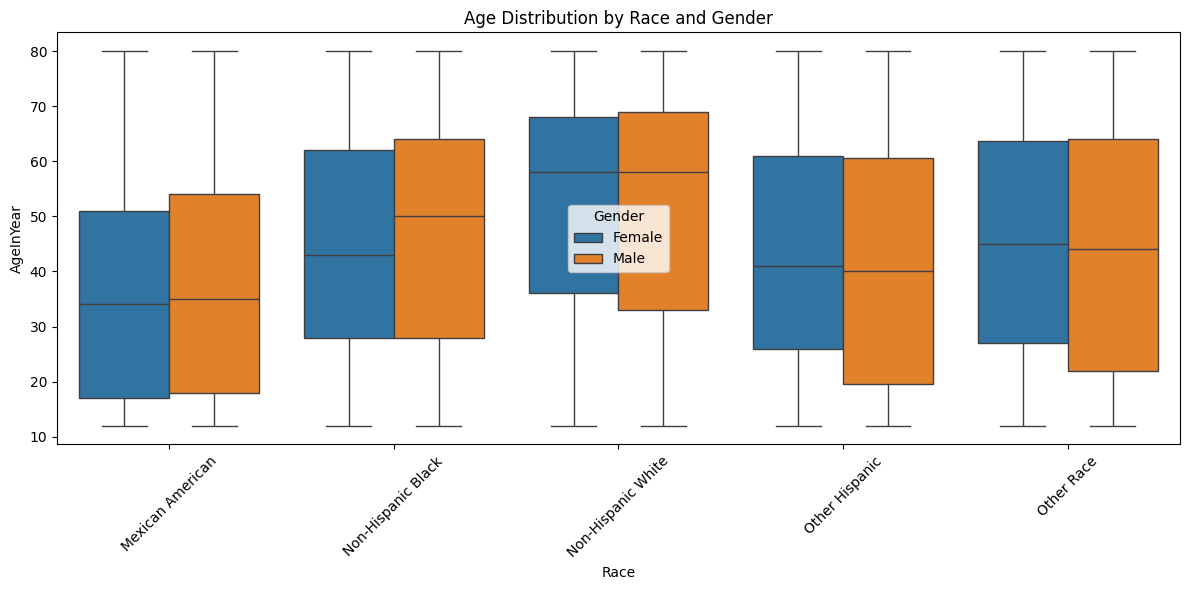

In [42]:
grouped_age = clean_data.groupby(['Race', 'Gender'])['AgeInYear'].describe().unstack()
print("Age Statistics by Race and Gender:")
print(grouped_age)

plt.figure(figsize=(12, 6))
sns.boxplot(data=clean_data, x='Race', y='AgeInYear', hue='Gender')
plt.title("Age Distribution by Race and Gender")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

It appears that within the Mexican American group, females tend to be slightly younger on average compared to males, and the age range for both genders is quite broad. For the Non-Hispanic Black group, the median ages for males and females look quite similar, with a noticeable spread in ages for both. In the Non-Hispanic White category, males seem to have a slightly higher median age and a wider interquartile range compared to females. The Other Hispanic group shows a lower median age for females compared to males, and the age distribution for males seems more spread out. Finally, the Other Race category suggests a similar median age for both genders, but with a wider spread in ages observed for males. Overall, while there are some variations in median ages and age ranges between genders within each racial group, there doesn't appear to be a consistent pattern of one gender being significantly older or younger across all racial categories in this dataset.

### Correlation of dietary components and BMI/Glycohemoglobin

We identify calculate the correlation of dietary components with 2 important measurements: BMI and Glycohemoglobin. Then we plot the top contributing factors to see how they impact people' health. 

In [43]:
# Get all numerical dietary variables from the diet dataset
numerical_diet_cols = diet.select_dtypes(include=['number']).columns.tolist()

# Ensure these variables exist in the clean_data dataframe
available_vars = [var for var in numerical_diet_cols if var in clean_data.select_dtypes(include=['number']).columns]
print(f"Found {len(available_vars)} dietary numerical components for analysis")

# Compute correlation coefficients for each available dietary component with BMI and Glycohemoglobin
corr_data = {'DietComponent': [], 'BMI_corr': [], 'Gly_corr': [], 'Abs_BMI_corr': [], 'Abs_Gly_corr': []}
for var in available_vars:
    bmi_corr = clean_data['BMI'].corr(clean_data[var])
    gly_corr = clean_data['Glycohemoglobin'].corr(clean_data[var])
    corr_data['DietComponent'].append(var)
    corr_data['BMI_corr'].append(bmi_corr)
    corr_data['Gly_corr'].append(gly_corr)
    corr_data['Abs_BMI_corr'].append(abs(bmi_corr))
    corr_data['Abs_Gly_corr'].append(abs(gly_corr))

# Convert to DataFrame for easier manipulation
corr_df = pd.DataFrame(corr_data)

# Get the top 5 factors for BMI correlation
top5_bmi = corr_df.sort_values('Abs_BMI_corr', ascending=False).head(5)
# Get the top 5 factors for Glycohemoglobin correlation
top5_gly = corr_df.sort_values('Abs_Gly_corr', ascending=False).head(5)

# Combine the unique top factors (might be less than 10 if there's overlap)
top_factors = pd.concat([top5_bmi, top5_gly]).drop_duplicates('DietComponent')
print(f"Top contributing dietary factors: {len(top_factors)}")

# Prepare a ColumnDataSource for Bokeh
source = ColumnDataSource(data={
    'DietComponent': top_factors['DietComponent'].tolist(),
    'BMI_corr': top_factors['BMI_corr'].tolist(),
    'Gly_corr': top_factors['Gly_corr'].tolist()
})

# Create a grouped bar chart:
#   - Blue bars for BMI correlation
#   - Green bars for Glycohemoglobin correlation
p = figure(x_range=top_factors['DietComponent'].tolist(), height=500, width=800,
           title="Top Dietary Components Correlating with BMI and Glycohemoglobin",
           toolbar_location="right", tools="hover,pan,wheel_zoom,box_zoom,reset,save")

bar_width = 0.35
p.vbar(x=dodge('DietComponent', -bar_width/2, range=p.x_range), top='BMI_corr', source=source,
       width=bar_width, color="blue", legend_label="BMI Correlation")
p.vbar(x=dodge('DietComponent', bar_width/2, range=p.x_range), top='Gly_corr', source=source,
       width=bar_width, color="green", legend_label="Glycohemoglobin Correlation")

# Add a horizontal line at y=0
p.line(x=[-0.5, len(top_factors)-0.5], y=[0, 0], line_color='black', line_dash='dashed', line_width=1)

# Format the plot
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.y_range.start = -max(abs(min(top_factors['BMI_corr'].min(), top_factors['Gly_corr'].min())), 
                       abs(max(top_factors['BMI_corr'].max(), top_factors['Gly_corr'].max()))) * 1.1
p.y_range.end = max(abs(min(top_factors['BMI_corr'].min(), top_factors['Gly_corr'].min())), 
                    abs(max(top_factors['BMI_corr'].max(), top_factors['Gly_corr'].max()))) * 1.1
p.xaxis.major_label_orientation = np.pi/4
p.xaxis.axis_label = "Dietary Component"
p.yaxis.axis_label = "Correlation Coefficient"
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

# Configure hover tool
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Component", "@DietComponent"),
    ("BMI Correlation", "@BMI_corr{0.000}"),
    ("Glycohemoglobin Correlation", "@Gly_corr{0.000}")
]

show(p)

# Print the actual values for reference
print("\nTop correlations with BMI:")
for _, row in top5_bmi.iterrows():
    print(f"  {row['DietComponent']}: {row['BMI_corr']:.4f}")

print("\nTop correlations with Glycohemoglobin:")
for _, row in top5_gly.iterrows():
    print(f"  {row['DietComponent']}: {row['Gly_corr']:.4f}")

Found 74 dietary numerical components for analysis
Top contributing dietary factors: 9



Top correlations with BMI:
  DietFiber: -0.0943
  TotalFolate: -0.0866
  FolateDFE: -0.0810
  Magnesium: -0.0795
  FoodFolate: -0.0780

Top correlations with Glycohemoglobin:
  Alcohol: -0.0542
  Caffeine: 0.0517
  D1Weight: -0.0502
  VitaminE: -0.0479
  FolateDFE: -0.0471


This bar chart illustrates the correlation coefficients between various top dietary components and two health indicators: Body Mass Index (BMI) and Glycohemoglobin. 
For instance, dietary fiber, total folate, folate DFE, lutein + zeaxanthin, and iron all show negative correlations with both BMI and Glycohemoglobin, suggesting that higher intake of these components is associated with lower BMI and Glycohemoglobin levels. Alcohol also exhibits a negative correlation with both, though the correlation with Glycohemoglobin appears stronger. In contrast, D1 Weight shows a positive correlation with BMI and a negative correlation with Glycohemoglobin. Notably, caffeine displays a positive correlation with BMI and a relatively strong positive correlation with Glycohemoglobin, indicating that higher caffeine consumption might be associated with higher levels of both indicators in this dataset. The magnitudes of the bars provide a sense of the strength of these associations.

### Diabetes group analysis

We create a function to classify the glycohemoglobin into diabetes category 

In [44]:
# Function to classify the diabetes status based on Glycohemoglobin measurements
def classify_single_value(hba1c):
        try:
            hba1c = float(hba1c)
            if np.isnan(hba1c):
                return np.nan
            if hba1c < 5.7:
                return 'Normal'
            elif 5.7 <= hba1c <= 6.4:
                return 'Pre-diabetic'
            else:  
                return 'Diabetic'
        except (ValueError, TypeError):
            return np.nan

Add another column for the diabete status

In [45]:
clean_data['DiabetesStatus'] = clean_data["Glycohemoglobin"].apply(classify_single_value)
clean_data['DiabetesStatus'].value_counts()

DiabetesStatus
Normal          4354
Pre-diabetic    2124
Diabetic         721
Name: count, dtype: int64

### Distribution of Age, Waist Circumference, BMI and Blood pressure by Diabetes Status

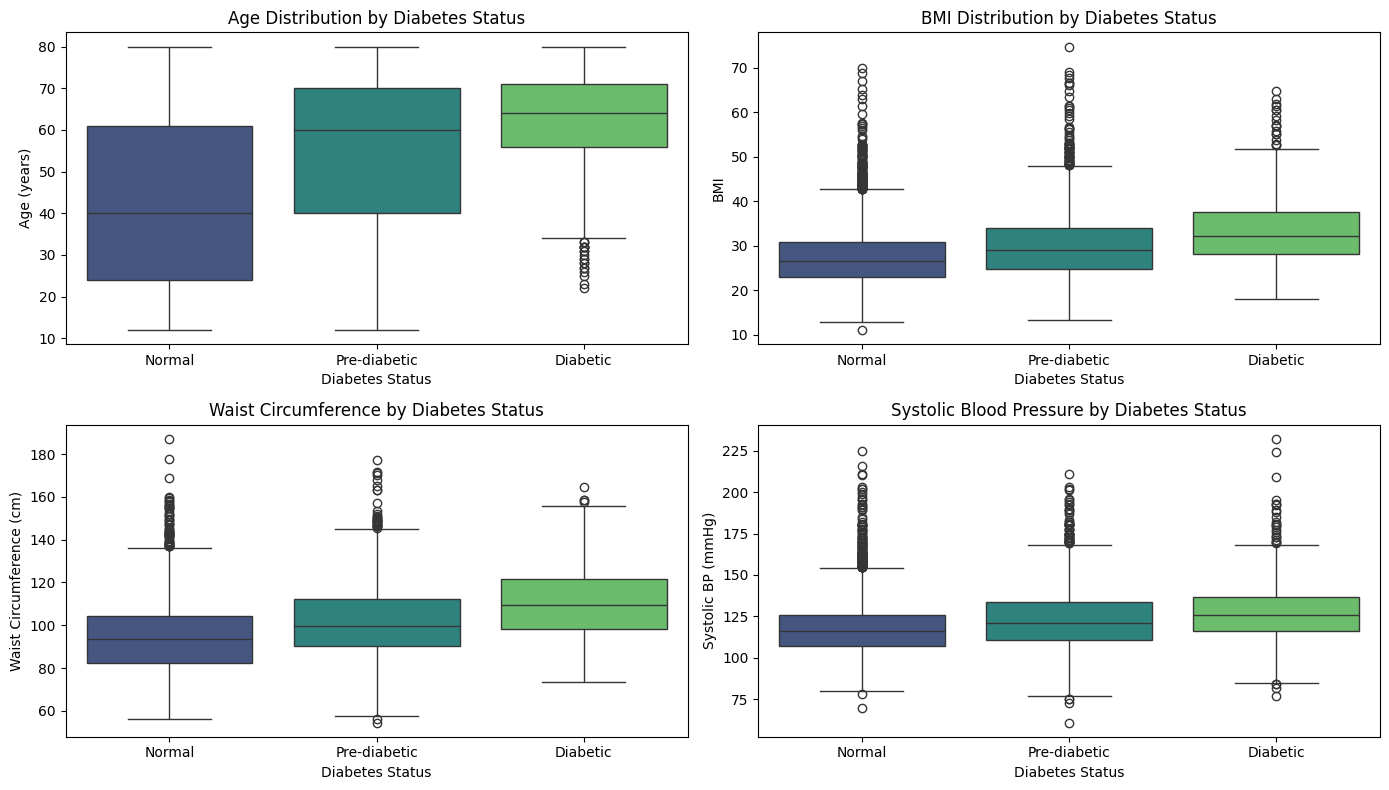

In [46]:
# Age distribution by diabetes status
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x='DiabetesStatus', y='AgeInYear', data=clean_data, palette='viridis')
plt.title('Age Distribution by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Age (years)')
    
    # BMI distribution by diabetes status
plt.subplot(2, 2, 2)
sns.boxplot(x='DiabetesStatus', y='BMI', data=clean_data, palette='viridis')
plt.title('BMI Distribution by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('BMI')
    
    # Waist circumference by diabetes status
plt.subplot(2, 2, 3)
sns.boxplot(x='DiabetesStatus', y='WaistCircumference', data=clean_data, palette='viridis')
plt.title('Waist Circumference by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Waist Circumference (cm)')
    
    # Blood pressure by diabetes status
plt.subplot(2, 2, 4)
sns.boxplot(x='DiabetesStatus', y='Systolic1', data=clean_data, palette='viridis')
plt.title('Systolic Blood Pressure by Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Systolic BP (mmHg)')
    
plt.tight_layout()
plt.show()
    

The top-left plot shows the Age Distribution by Diabetes Status. We can observe a clear trend of increasing age across the categories. The Normal group has the lowest median age, followed by the Pre-diabetic group, and the Diabetic group exhibits the highest median age. Additionally, the spread of ages appears to be wider in the Diabetic group, with some younger individuals also falling into this category.

The top-right plot illustrates the BMI Distribution by Diabetes Status. Here, we see a similar trend of increasing median BMI from the Normal to the Pre-diabetic to the Diabetic group. The Diabetic group also displays a wider range of BMI values and more potential outliers at the higher end compared to the Normal and Pre-diabetic groups.

The bottom-left plot depicts the Waist Circumference by Diabetes Status. Again, the median waist circumference increases from the Normal to the Pre-diabetic to the Diabetic group. The spread of waist circumference also seems to widen with increasing diabetes status, and there are notable outliers, particularly at higher waist circumferences, in the Pre-diabetic and Diabetic groups.

Finally, the bottom-right plot shows the Systolic Blood Pressure by Diabetes Status. While the trend is less pronounced compared to age, BMI, and waist circumference, there is a tendency for systolic blood pressure to be higher in the Pre-diabetic and Diabetic groups compared to the Normal group. The Diabetic group shows the highest median systolic blood pressure and the widest distribution, with several high outliers.

### Risk factor analysis

We create a scatter plot for the risk factors

In [47]:
# Create a scatter plot matrix of key risk factors
diabetes_colors = {'Normal': '#2b83ba', 'Pre-diabetic': '#fdae61', 'Diabetic': '#d7191c'}
    
# Select subset of data for visualization
sample_size = min(3000, len(clean_data))
viz_data = clean_data.copy()
    
# Create data source for Bokeh
source = ColumnDataSource(data={
    'x': viz_data['BMI'].values,
    'y': viz_data['AgeInYear'].values,
    'waist': viz_data['WaistCircumference'].values,
    'glyco': viz_data['Glycohemoglobin'].values,
    'status': viz_data['DiabetesStatus'].values,
    'gender': viz_data['Gender'].values,
    'systolic': viz_data['Systolic1'].values,
    'energy': viz_data['Energy'].values
})
    
# Create figure
p = figure(
    width=800, height=600,
    title="Diabetes Risk Factors Analysis",
    tools="pan,wheel_zoom,box_zoom,reset,hover,save",
    x_axis_label="BMI",
    y_axis_label="Age (years)"
)
    
# Create separate scatter plots for each status category
for status, color in diabetes_colors.items():
    status_data = viz_data[viz_data['DiabetesStatus'] == status]
    if len(status_data) > 0:
        source_filtered = ColumnDataSource(data={
            'x': status_data['BMI'].values,
            'y': status_data['AgeInYear'].values,
            'waist': status_data['WaistCircumference'].values,
            'glyco': status_data['Glycohemoglobin'].values,
            'status': status_data['DiabetesStatus'].values,
            'gender': status_data['Gender'].values,
            'systolic': status_data['Systolic1'].values
        })
        
        p.circle(
            x='x', y='y', 
            source=source_filtered,
            size=8,
            color=color,
            alpha=0.7,
            legend_label=f"{status} ({len(status_data)})",
            line_color="white",
            line_width=0.5
        )
    
# Configure hover tooltip
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("BMI", "@x{0.2f}"),
    ("Age", "@y{0.0f}"),
    ("Waist Circ.", "@waist{0.1f} cm"),
    ("Glycohemoglobin", "@glyco{0.1f}%"),
    ("Diabetes Status", "@status"),
    ("Gender", "@gender"),
    ("Systolic BP", "@systolic{0.0f} mmHg")
]
    
# Configure legend
p.legend.location = "top_left"
p.legend.click_policy = "hide"
    
# Show the plot
show(p)

Looking at the distribution of points, we can observe several trends. The blue points, representing individuals with a normal diabetes status, are spread across a wide range of ages and BMI values, though they appear to be more concentrated in the younger age groups and lower to moderate BMI ranges.

The orange points, indicating pre-diabetic individuals, tend to be clustered in the middle to older age ranges and in the overweight to obese BMI categories. There's a noticeable overlap with the normal group, particularly in the younger, higher BMI ranges and the older, lower BMI ranges.

The red points, representing individuals with diabetes, are predominantly found in the older age groups and higher BMI ranges, with a significant concentration in the obese category (BMI > 30) and ages above 50. However, it's important to note that there are also individuals with diabetes at younger ages and lower BMIs, although they are less frequent.

Overall, the plot suggests a positive association between both age and BMI with the likelihood of being pre-diabetic or diabetic. As individuals get older and their BMI increases, they are more likely to fall into the pre-diabetic and then diabetic categories. While there are individuals with normal diabetes status across all age and BMI ranges, the prevalence of pre-diabetes and diabetes clearly increases in older individuals and those with higher BMIs. This visualization underscores the importance of maintaining a healthy weight and understanding the increased risk of dysglycemia with age.

### Odd ratio for risk factors

We combine the normal and pre-diabetic class into one section so that we can perform binary analysis on odd ratio. Then we plot each risk factor's odds of being diagnosed as diabetes


Odds Ratios for Diabetes Risk Factors:
  High Age: OR = 3.11 (95% CI: 2.81-3.43)
  High Waist Circ: OR = 2.58 (95% CI: 2.34-2.85)
  High BMI: OR = 2.28 (95% CI: 2.06-2.51)
  High Blood Pressure: OR = 2.12 (95% CI: 1.91-2.36)
  Low Fiber: OR = 1.06 (95% CI: 0.96-1.16)
  High Sugar: OR = 1.00 (95% CI: 0.89-1.13)


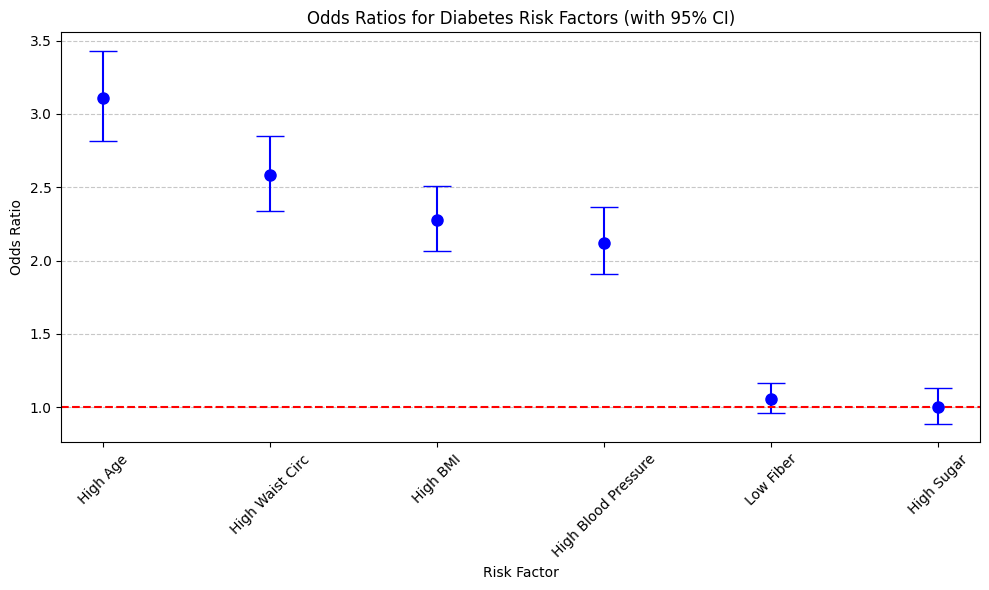

In [48]:
# For simplicity, combine pre-diabetic and diabetic into one group for binary analysis
clean_data['DiabetesBinary'] = clean_data['DiabetesStatus'].apply(
        lambda x: 0 if x == 'Normal' else 1)
    
    # Define risk factor thresholds
risk_factors = {
        'High BMI': clean_data['BMI'] >= 30,
        'High Waist Circ': clean_data['WaistCircumference'] >= 102,  # Men threshold, simplified
        'High Blood Pressure': clean_data['Systolic1'] >= 130,
        'High Age': clean_data['AgeInYear'] >= 60,
        'Low Fiber': clean_data['DietFiber'] <= 15,
        'High Sugar': clean_data['Sugar'] >= 50
}
    
# Function to calculate odds ratio
def calculate_odds_ratio(factor, outcome):
        a = sum((factor) & (outcome == 1))  # Risk factor present, disease present
        b = sum((factor) & (outcome == 0))  # Risk factor present, disease absent
        c = sum((~factor) & (outcome == 1))  # Risk factor absent, disease present
        d = sum((~factor) & (outcome == 0))  # Risk factor absent, disease absent
        
        # Add 0.5 to each cell to handle zero counts
        a, b, c, d = a + 0.5, b + 0.5, c + 0.5, d + 0.5
        
        odds_ratio = (a * d) / (b * c)
        # Calculate confidence interval
        log_or = np.log(odds_ratio)
        se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
        ci_lower = np.exp(log_or - 1.96 * se_log_or)
        ci_upper = np.exp(log_or + 1.96 * se_log_or)
        
        return odds_ratio, ci_lower, ci_upper, a-0.5, b-0.5, c-0.5, d-0.5
    
    # Calculate odds ratios for each risk factor
odds_ratios = []
for factor_name, factor in risk_factors.items():
        or_value, ci_lower, ci_upper, a, b, c, d = calculate_odds_ratio(
            factor, clean_data['DiabetesBinary'])
        odds_ratios.append({
            'Risk Factor': factor_name,
            'Odds Ratio': or_value,
            'CI Lower': ci_lower,
            'CI Upper': ci_upper,
            'With Risk & Diabetes': a,
            'With Risk & Normal': b,
            'Without Risk & Diabetes': c,
            'Without Risk & Normal': d
})
    
    # Create DataFrame of odds ratios
or_df = pd.DataFrame(odds_ratios)
or_df = or_df.sort_values('Odds Ratio', ascending=False)
    
    # Print odds ratio table
print("\nOdds Ratios for Diabetes Risk Factors:")
for idx, row in or_df.iterrows():
        print(f"  {row['Risk Factor']}: OR = {row['Odds Ratio']:.2f} " +
              f"(95% CI: {row['CI Lower']:.2f}-{row['CI Upper']:.2f})")
    
    # Plot odds ratios
plt.figure(figsize=(10, 6))
plt.errorbar(
        x=or_df['Risk Factor'],
        y=or_df['Odds Ratio'],
        yerr=[(or_df['Odds Ratio'] - or_df['CI Lower']), 
              (or_df['CI Upper'] - or_df['Odds Ratio'])],
        fmt='o',
        capsize=10,
        color='blue',
        markersize=8
    )
plt.axhline(y=1, color='red', linestyle='--')
plt.title('Odds Ratios for Diabetes Risk Factors (with 95% CI)')
plt.ylabel('Odds Ratio')
plt.xlabel('Risk Factor')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
    

This chart, an interval plot displaying odds ratios (ORs) with 95% confidence intervals (CIs) for various diabetes risk factors, clearly illustrates the strength and statistical significance of each factor. "High Age" shows the strongest association with diabetes, boasting an OR of 3.11, meaning individuals in the higher age group are over three times more likely to have diabetes compared to the reference group, with its confidence interval (2.81-3.43) well above 1.00. Similarly, "High Waist Circ" (OR = 2.58, 95% CI: 2.34-2.85), "High BMI" (OR = 2.28, 95% CI: 2.06-2.51), and "High Blood Pressure" (OR = 2.12, 95% CI: 1.91-2.36) also demonstrate statistically significant positive associations with diabetes, as their confidence intervals do not overlap with 1.00, which represents no association. In contrast, "Low Fiber" (OR = 1.06, 95% CI: 0.96-1.16) and "High Sugar" (OR = 1.00, 95% CI: 0.89-1.13) do not show a statistically significant association with diabetes, as their 95% confidence intervals cross or include 1.00, indicating that any observed association could be due to chance.

**Previously, we have implemented fundamental exploratory data analysis on the merged dataset and uncover some interesting insights about data distribution, statistics and correlation. We also discovered how dietary components, demographic information and certain measurements are related to diabetes status. In the next part, we will even dig deeper into the dataset and find more complicated and high-level insights and pattern about diabetes through clustering models**

## 5. Data Preprocessing

Data preprocessing is a crucial part for any model training. This process includes scaling data, encoding the labels and finalizing the inputs.

### Scale data

In [49]:
clean_data

SEQN  ReleaseCycle         InterviewStatus  Gender  AgeInYear  \
0     130378.0          12.0  Both Interview and MEC    Male       43.0   
1     130379.0          12.0  Both Interview and MEC    Male       66.0   
2     130380.0          12.0  Both Interview and MEC  Female       44.0   
3     130386.0          12.0  Both Interview and MEC    Male       34.0   
4     130387.0          12.0  Both Interview and MEC  Female       68.0   
...        ...           ...                     ...     ...        ...   
7194  142305.0          12.0  Both Interview and MEC  Female       76.0   
7195  142307.0          12.0  Both Interview and MEC  Female       49.0   
7196  142308.0          12.0  Both Interview and MEC    Male       50.0   
7197  142309.0          12.0  Both Interview and MEC    Male       40.0   
7198  142310.0          12.0  Both Interview and MEC  Female       80.0   

                    Race     RaceWithNHAsian      6MonthPeriod CountryOfBirth  \
0             Other Race  Non-Hispanic Asian    May 1 - Oct 31         Others   
1     Non-Hispanic White  Non-Hispanic White    May 1 - Oct 31             US   
2         Other Hispanic      Other Hispanic  Nov 1 - April 30         Others   
3       Mexican American    Mexican American  Nov 1 - April 30             US   
4     Non-Hispanic White  Non-Hispanic White    May 1 - Oct 31             US   
...                  ...                 ...               ...            ...   
7194    Mexican American    Mexican American    May 1 - Oct 31         Others   
7195  Non-Hispanic Black  Non-Hispanic Black    May 1 - Oct 31             US   
7196      Other Hispanic      Other Hispanic  Nov 1 - April 30         Others   
7197      Other Hispanic      Other Hispanic  Nov 1 - April 30             US   
7198  Non-Hispanic White  Non-Hispanic White  Nov 1 - April 30             US   

      PeopleInHousehold  ...  Diastolic2  Systolic3  Diastolic3  Pulse1  \
0                   4.0  ...        96.0      132.0        94.0    82.0   
1                   2.0  ...        76.0      113.0        76.0    72.0   
2                   7.0  ...        80.0      104.0        76.0    84.0   
3                   3.0  ...        74.0      115.0        75.0    59.0   
4                   1.0  ...        74.0      145.0        78.0    80.0   
...                 ...  ...         ...        ...         ...     ...   
7194                4.0  ...        78.0      144.0        79.0    71.0   
7195                5.0  ...        73.0      131.0        72.0    71.0   
7196                3.0  ...        69.0      112.0        74.0    58.0   
7197                5.0  ...        82.0      128.0        81.0    80.0   
7198                2.0  ...        78.0      129.0        81.0    77.0   

      Pulse2  Pulse3  PhlebotomyWeight Glycohemoglobin  DiabetesStatus  \
0       79.0    82.0      5.604213e+04        5.600000          Normal   
1       71.0    73.0      3.743571e+04        5.600000          Normal   
2       83.0    77.0      8.532884e+04        6.200000    Pre-diabetic   
3       64.0    64.0      4.452621e+04        5.100000          Normal   
4       80.0    77.0      2.274630e+04        5.900000    Pre-diabetic   
...      ...     ...               ...             ...             ...   
7194    70.0    71.0      4.971093e+04        6.000000    Pre-diabetic   
7195    70.0    67.0      6.899418e+04        6.200000    Pre-diabetic   
7196    61.0    69.0      5.397605e-79        5.709471    Pre-diabetic   
7197    79.0    83.0      4.628442e+04        5.200000          Normal   
7198    78.0    79.0      5.325082e+04        5.300000          Normal   

     DiabetesBinary  
0                 0  
1                 0  
2                 1  
3                 0  
4                 1  
...             ...  
7194              1  
7195              1  
7196              1  
7197              0  
7198              0  

[7199 rows x 127 columns]

In [50]:
missing = clean_data.isnull().sum()

missing_cols = missing[missing > 0]
print(missing_cols)

Series([], dtype: int64)


### Build the pipeline to transform numerical and categorical features

Our pipeline contains a Robust scaler to scale all the numerical features to a same range and nicely handle all the outliers. There is also an Ordinal Encoder to transform the categorical data into numbers so that the model can process them. 

In [51]:
from sklearn.manifold import TSNE
# We take the diabetes status as the ground truth to evaluate the model
target = clean_data['DiabetesStatus']
features = clean_data.drop(columns=["SEQN","DiabetesStatus", "Glycohemoglobin"])

numeric_columns.pop(-1)
# Robust scaler to scale the numeric data
numeric_pipeline = Pipeline([
    ('scaler', RobustScaler())

])
#Ordinal Encoder to encode the categorical data
categorical_pipeline = Pipeline([
    ('encoder', OrdinalEncoder())
])

#Assign proper transformer to each column
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_columns),
    ('cat', categorical_pipeline, categorical_columns)
], remainder='drop')

full_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('pca', TSNE(n_components=3, random_state=42))
])

#Transform the whole dataset
transformed_features = full_pipeline.fit_transform(features)
print("Transformed Features Shape: ", transformed_features.shape)
print(transformed_features)


Transformed Features Shape:  (7199, 3)
[[-20.136618   -2.786999    6.8539257]
 [-11.639378   -7.0647473 -28.411228 ]
 [ -9.432247   25.683222    2.3997917]
 ...
 [  9.482553   -1.1590735  18.372763 ]
 [ 24.321733  -22.210253   -7.722321 ]
 [-11.308098    3.9146662 -23.286116 ]]


The final data has nearly 7200 instances and is ready for the model!

## 6. Clustering Model Implementation

### Find optimal number of k

For Kmeans model, we need to initialize the number of clusters. There are two ways of finding the optimal number of clusters (or `k`), which are KElbow and Silhouette method. 

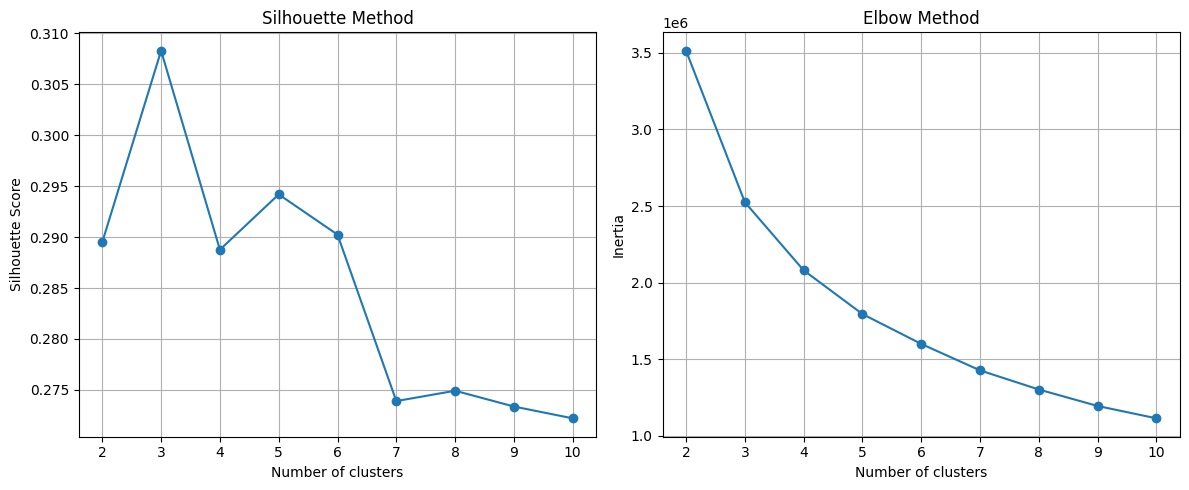

In [52]:
from sklearn.metrics import silhouette_score

# Find optimal number of clusters
silhouette_scores = []
inertia_values = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(transformed_features)
    silhouette_scores.append(silhouette_score(transformed_features, cluster_labels))
    inertia_values.append(kmeans.inertia_)

# Plot to determine optimal k
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, inertia_values, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.tight_layout()
plt.show()

Analysis of the Silhouette Method Graph:
The highest silhouette score is observed at 3 clusters, with a score significantly nearly 0.32. This suggests that dividing the data into two clusters results in the most distinct and well-separated groups according to this metric.
There's a sharp drop in the silhouette score when moving from 3 to 4 clusters.
The silhouette scores continues to drop between 5 and 8 clusters, hovering around 0.28.

Analysis of the Elbow Method Graph:
The inertia starts high at 2 clusters and generally decreases as the number of clusters increases. This is expected because with more clusters, data points are closer to their respective centroids, reducing the within-cluster sum of squares.
The rate of decrease in inertia appears to be most significant between 2 and 4 clusters.
There's a noticeable change in the rate of decrease (a potential "elbow") around 3 clusters. After 3 clusters, the decrease in inertia becomes less steep.
All in all, the optimal k should be 3



### Fit the Kmeans model

In [53]:
optimal_k = 3

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(transformed_features)


### Find the best $\epsilon$

We plot the K-distance graph to identify the 'knee' point in the graph

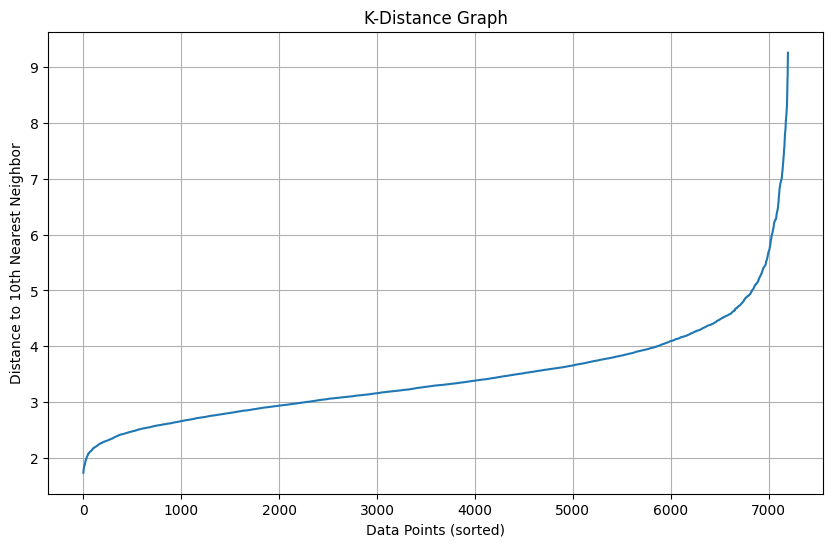

In [54]:
from sklearn.neighbors import NearestNeighbors

# Find optimal epsilon parameter
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(transformed_features)
distances, indices = neighbors_fit.kneighbors(transformed_features)

# Sort distances to k-th nearest neighbor
distances = np.sort(distances[:, 9])  # 10th neighbor

# Plot k-distance graph to find the elbow
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points (sorted)')
plt.ylabel('Distance to 10th Nearest Neighbor')
plt.title('K-Distance Graph')
plt.grid(True)
plt.show()

Based on visual inspection, the point where the curve really starts to accelerate upwards, indicating where points are no longer in a dense region relative to their neighbors, appears to be when the y-axis value (distance) is approximately between 5 and 6. Therefore, we will try with epsilon = 6

### Fit the DBSCAN model

In [55]:
# Set DBSCAN parameters based on the k-distance plot
eps = 5.5  # Choose where the "elbow" occurs in the plot
min_samples = 8 # Minimum points to form a dense region

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(transformed_features)

# Count clusters and noise points
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f'DBSCAN found {n_clusters} clusters and {n_noise} noise points')


DBSCAN found 3 clusters and 69 noise points


## 7. Model Evaluation and Visualisation

In [56]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score

# For DBSCAN evaluation, we'll exclude noise points
non_noise_idx = dbscan_labels != -1
if sum(non_noise_idx) > 0 and len(set(dbscan_labels[non_noise_idx])) > 1:
    # Calculate metrics excluding noise points
    dbscan_silhouette = silhouette_score(
        transformed_features[non_noise_idx], 
        dbscan_labels[non_noise_idx]
    )
    dbscan_ari = adjusted_rand_score(
        target[non_noise_idx], 
        dbscan_labels[non_noise_idx]
    )
    dbscan_davies = davies_bouldin_score(
        transformed_features[non_noise_idx], 
        dbscan_labels[non_noise_idx]
    )
    
    print("\n----- DBSCAN Evaluation (excluding noise) -----")
    print(f"Silhouette Score: {dbscan_silhouette:.4f} (higher is better, range: [-1, 1])")
    print(f"Adjusted Rand Index: {dbscan_ari:.4f} (higher is better, range: [-1, 1])")
    print(f"Davies-Bouldin Index: {dbscan_davies:.4f} (lower is better)")
else:
    print("DBSCAN produced insufficient clusters for evaluation metrics")

# Calculate evaluation metrics for K-means
kmeans_silhouette = silhouette_score(transformed_features, kmeans_labels)
kmeans_ari = adjusted_rand_score(target, kmeans_labels)
kmeans_davies = davies_bouldin_score(transformed_features, kmeans_labels)

print("\n----- K-means Evaluation (k=3) -----")
print(f"Silhouette Score: {kmeans_silhouette:.4f} (higher is better, range: [-1, 1])")
print(f"Adjusted Rand Index: {kmeans_ari:.4f} (higher is better, range: [-1, 1])")
print(f"Davies-Bouldin Index: {kmeans_davies:.4f} (lower is better)")



----- DBSCAN Evaluation (excluding noise) -----
Silhouette Score: -0.0598 (higher is better, range: [-1, 1])
Adjusted Rand Index: 0.0003 (higher is better, range: [-1, 1])
Davies-Bouldin Index: 0.7962 (lower is better)

----- K-means Evaluation (k=3) -----
Silhouette Score: 0.3083 (higher is better, range: [-1, 1])
Adjusted Rand Index: 0.0014 (higher is better, range: [-1, 1])
Davies-Bouldin Index: 1.1307 (lower is better)


**Silhouette Score Comparison**: 

K-means (0.3083) significantly outperforms DBSCAN (-0.0598) in terms of silhouette score. This indicates that:
K-means created clusters with better separation and cohesion
- Data points in K-means clusters are much more similar to other points in their assigned cluster than to points in neighboring clusters
- DBSCAN's extremely low silhouette score (close to 0) suggests its clusters have unclear boundaries with many points potentially positioned between clusters

**Adjusted Rand Index (ARI)**

Both algorithms show very poor alignment with the true diabetes status labels:
- K-means ARI (0.0014) and DBSCAN ARI (0.0003) are essentially zero
- This indicates the clustering solutions from both algorithms are practically random with respect to the actual diabetes categories
- However, this should not be unfortunate as the models may have discovered interesting clusters that are different from the diabetes status

**Davies-Bouldin Index**

- DBSCAN (0.7962) performs better than K-means (1.1307) on this metric
- This suggests that DBSCAN produced:
More compact clusters with lower intra-cluster distances
Better separation between cluster centroids
However, this advantage is offset by its poor silhouette score

### Bar chart for models evaluation metrics

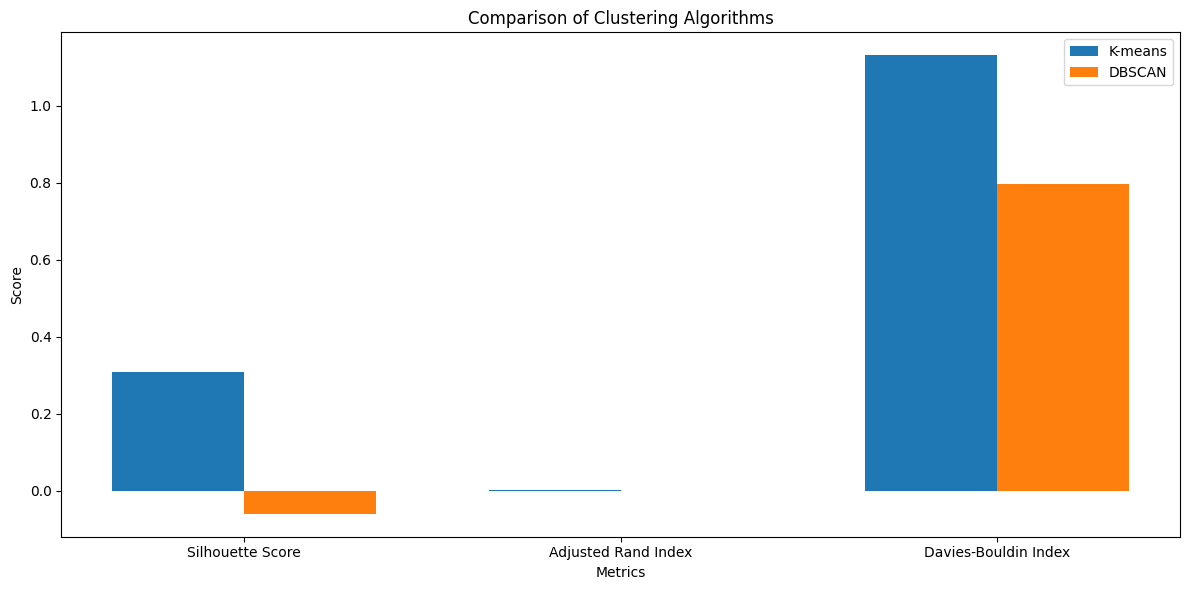


----- Comparative Analysis -----
Silhouette Score: K-means performs better
Adjusted Rand Index: K-means performs better
Davies-Bouldin Index: DBSCAN performs better


In [57]:
# Create a bar chart comparing metrics
metrics = ['Silhouette Score', 'Adjusted Rand Index', 'Davies-Bouldin Index']
kmeans_scores = [kmeans_silhouette, kmeans_ari, kmeans_davies]

if 'dbscan_silhouette' in locals():
    dbscan_scores = [dbscan_silhouette, dbscan_ari, dbscan_davies]
    
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(metrics))
    
    plt.bar(index, kmeans_scores, bar_width, label='K-means')
    plt.bar(index + bar_width, dbscan_scores, bar_width, label='DBSCAN')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Comparison of Clustering Algorithms')
    plt.xticks(index + bar_width/2, metrics)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print comparative analysis
    print("\n----- Comparative Analysis -----")
    for i, metric in enumerate(metrics):
        better = "K-means" if kmeans_scores[i] > dbscan_scores[i] else "DBSCAN"
        if metric == "Davies-Bouldin Index":
            better = "K-means" if kmeans_scores[i] < dbscan_scores[i] else "DBSCAN"
        print(f"{metric}: {better} performs better")

### Plot the clusters in 3D

In order to plot the data with its corresponding cluster label, we need to reduce the dimensionality to 3. Then we draw a scatter plot to visualize how well the model clustered the data.

Using first 3 components of the already transformed data


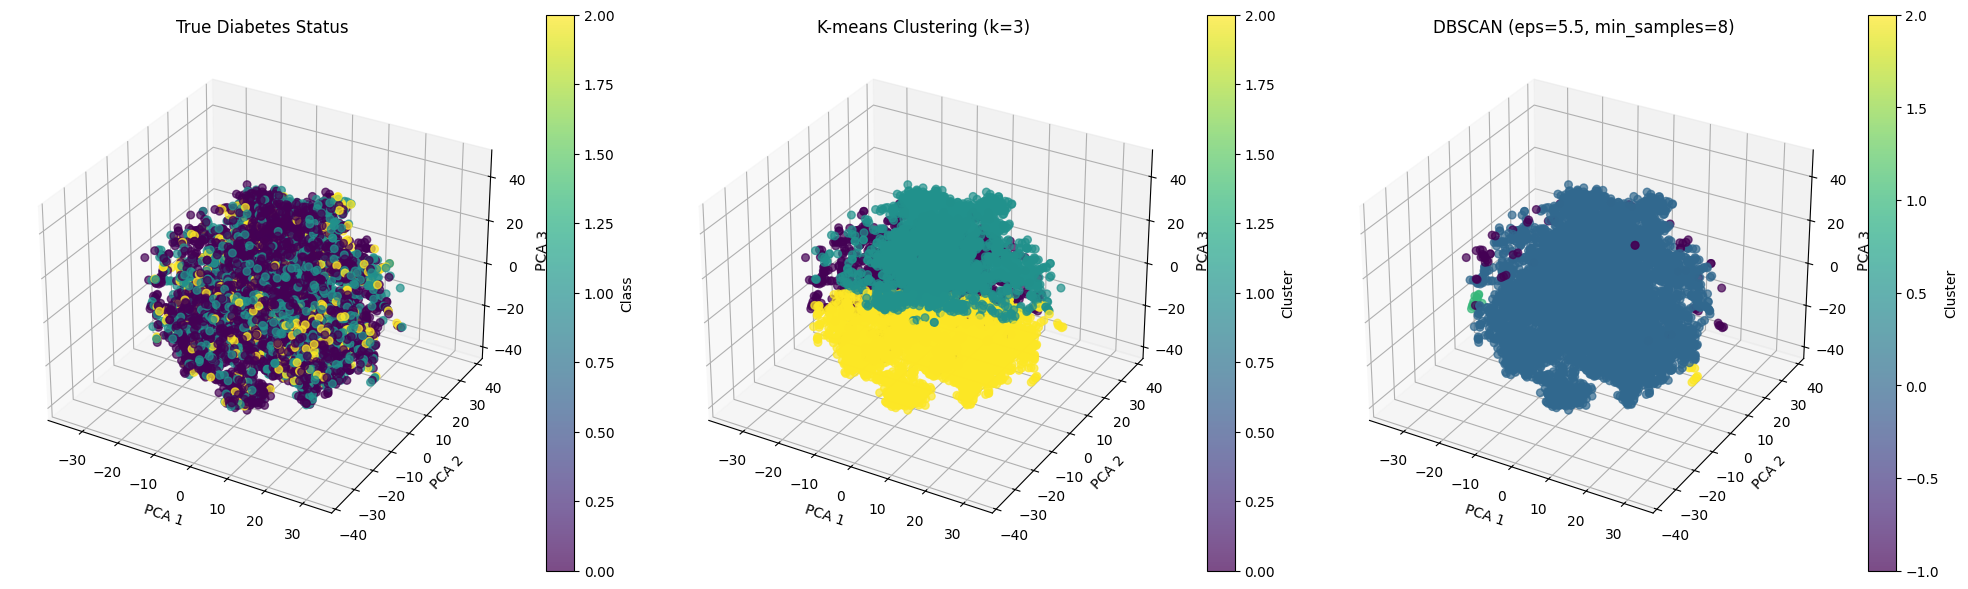

In [58]:
# 6. Visualize results in 3D (PCA for 3D visualization)
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


features_3d = transformed_features[:, :3]
print(f"Using first 3 components of the already transformed data")

# Create diabetes classes using clinical thresholds
def create_diabetes_classes(values):
    classes = []
    for val in values:
        if val == "Normal":
            classes.append(0)  # Normal
        elif val == "Pre-diabetic":
            classes.append(1)  # Prediabetic
        else:
            classes.append(2)  # Diabetic
    return np.array(classes)

true_classes = create_diabetes_classes(target)
y = clean_data["Glycohemoglobin"]

# Plot results in 3D
fig = plt.figure(figsize=(20, 6))

# True Diabetes Status 3D
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], 
                      c=true_classes, cmap='viridis', alpha=0.7, s=30)
ax1.set_title('True Diabetes Status')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
fig.colorbar(scatter1, ax=ax1, label='Class')

# K-means clusters 3D
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], 
                      c=kmeans_labels, cmap='viridis', alpha=0.7, s=30)
ax2.set_title(f'K-means Clustering (k={optimal_k})')
ax2.set_xlabel('PCA 1')
ax2.set_ylabel('PCA 2')
ax2.set_zlabel('PCA 3')
fig.colorbar(scatter2, ax=ax2, label='Cluster')

# DBSCAN clusters 3D
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], 
                      c=dbscan_labels, cmap='viridis', alpha=0.7, s=30)
ax3.set_title(f'DBSCAN (eps={eps}, min_samples={min_samples})')
ax3.set_xlabel('PCA 1')
ax3.set_ylabel('PCA 2')
ax3.set_zlabel('PCA 3')
fig.colorbar(scatter3, ax=ax3, label='Cluster')

plt.tight_layout()
plt.show()



This series of three 3D scatter plots visualizes the effectiveness of K-Means and DBSCAN clustering algorithms compared to the true diabetes status, presumably after dimensionality reduction (indicated by PCA 1, PCA 2, and PCA 3 axes). The first plot, "True Diabetes Status," reveals a complex, interwoven distribution of two classes (represented by yellow and purple/dark blue), suggesting a non-linearly separable dataset. The middle plot, "K-Means Clustering (k=3)," attempts to group the data into three clusters, clearly showing two distinct, somewhat spherical clusters (yellow and purple) with a third, smaller green cluster at the boundary. While K-Means creates well-defined geometric clusters, it struggles to align with the true, more amorphous boundaries, as seen by the significant mixing of true classes within the K-Means generated clusters. In stark contrast, the third plot, "DBSCAN (eps=6, min_samples=6)," produces essentially a single, large, undifferentiated cluster with most points assigned to one main group (dark blue) and very few, if any, points classified as noise or separate small clusters. This outcome suggests that the chosen epsilon and min_samples values for DBSCAN are too large relative to the inherent density variations in the t-SNE-transformed data, causing it to perceive almost the entire dataset as one dense region, thereby failing to delineate any meaningful substructures present in the true diabetes status.

### Evaluation of clusters in 2D plot

The code creates interactive visualizations and analyzes clustering results (K-means and DBSCAN) in relation to diabetes status. It generates 2D scatter plots using PCA-reduced data, displaying true diabetes status, K-means clusters, and DBSCAN clusters in separate tabs. It also calculates and prints cluster statistics, such as average glycohemoglobin levels and diabetes status proportions within each cluster. This helps evaluate how well the clustering methods align with the true diabetes status and provides insights into the characteristics of each cluster.

In [59]:
from bokeh.layouts import row as bokeh_row
# Create column data sources for each visualization
source_true = ColumnDataSource(data=dict(
    x=features_3d[:, 0],
    y=features_3d[:, 1],
    z=features_3d[:, 2],
    color=true_classes,
    label=target,
    glyco=y
))

source_kmeans = ColumnDataSource(data=dict(
    x=features_3d[:, 0],
    y=features_3d[:, 1],
    z=features_3d[:, 2],
    color=kmeans_labels,
    label=target,
    glyco=y
))

source_dbscan = ColumnDataSource(data=dict(
    x=features_3d[:, 0],
    y=features_3d[:, 1],
    z=features_3d[:, 2],
    color=dbscan_labels,
    label=target,
    glyco=y
))

# Create colormappers
true_mapper = linear_cmap(field_name='color', palette=Plasma256, low=min(true_classes), high=max(true_classes))
kmeans_mapper = linear_cmap(field_name='color', palette=Viridis256, low=min(kmeans_labels), high=max(kmeans_labels))
dbscan_mapper = linear_cmap(field_name='color', palette=Turbo256, low=min(dbscan_labels), high=max(dbscan_labels))

# Common tools for all plots
tools = "pan,wheel_zoom,box_zoom,reset,save,hover"

# Create the 3 sets of plots (for each dimension pair)
def create_dimension_plots(source, color_mapper, title, dimensions=[(0,1), (0,2), (1,2)]):
    plots = []
    for x_idx, y_idx in dimensions:
        p = figure(width=400, height=400, tools=tools, 
                  title=f"{title}: Dimensions {x_idx+1} vs {y_idx+1}")
        
        # Add scatter points
        scatter = p.circle('x', 'y', source=source, size=8, 
                           fill_color=color_mapper, line_color='black', alpha=0.7)
        
        # Configure hover tooltip
        hover = p.select_one(HoverTool)
        hover.tooltips = [
            ("PCA Dims", f"({x_idx+1},{y_idx+1})"),
            ("Coordinates", "(@x, @y)"),
            ("Glycohemoglobin", "@glyco"),
            ("Diabetes Status", "@label"),
            ("Cluster", "@color")
        ]
        
        # Axis labels
        p.xaxis.axis_label = f'PCA Dimension {x_idx+1}'
        p.yaxis.axis_label = f'PCA Dimension {y_idx+1}'
        
        plots.append(p)
    
    return plots

# Create plots for true diabetes status
true_plots = create_dimension_plots(source_true, true_mapper, "True Diabetes Status")
true_panel = TabPanel(child=bokeh_row(*true_plots), title="True Diabetes Status")

# Create plots for K-means
kmeans_plots = create_dimension_plots(source_kmeans, kmeans_mapper, f"K-means (k={optimal_k})")
kmeans_panel = TabPanel(child=bokeh_row(*kmeans_plots), title="K-means Clustering")

# Create plots for DBSCAN
dbscan_plots = create_dimension_plots(source_dbscan, dbscan_mapper, f"DBSCAN (eps={eps})")
dbscan_panel = TabPanel(child=bokeh_row(*dbscan_plots), title="DBSCAN Clustering")

# Put everything together in tabs
tabs = Tabs(tabs=[true_panel, kmeans_panel, dbscan_panel])

# Show the visualization
show(tabs)

1. True Diabetes Status

In all three plots, the two classes (yellow and dark purple/blue) are highly intermingled and spread across the entire data manifold. There are no clear, separable regions or distinct clusters for either class. The data points form a large, dense, and amorphous blob where both classes are extensively mixed.
This visually confirms the challenge of classifying or clustering this dataset. The t-SNE projection (which aims to preserve local neighborhoods) shows that the true diabetes status is not easily distinguishable based on these lower-dimensional representations. This suggests that even with dimensionality reduction, the underlying structure of the two classes is very complex and overlaps significantly in this feature space. This is a characteristic of a difficult classification problem or one where the classes are inherently not linearly separable in the transformed space.

2. K-Means Clustering (k=7)

K-Means with k=7 creates distinct, somewhat spherical or crescent-shaped clusters (represented by various colors: yellow, green, teal, purple/dark blue). In all three dimension pairs, K-Means carves the large data blob into these seven partitions. For instance, in "Dimensions 1 vs 2," we clearly see a bottom-left yellow cluster, a bottom-right green cluster, a central teal cluster, and an upper-right purple cluster, with other colors filling in.
K-Means, by its nature, forces the data into a predefined number of clusters, aiming to minimize within-cluster variance. While it successfully creates these partitions, we must compare them to the "True Diabetes Status." Given the high intermingling of the true classes, it's highly probable that these K-Means clusters contain a mix of both true diabetes classes. This means K-Means is grouping data points purely by their geometric proximity in the t-SNE space, without necessarily reflecting the underlying biological or medical categories. The choice of k=7 is arbitrary to the true labels and merely divides the existing dense manifold.

3. DBSCAN (eps=6)

In all three plots, the vast majority of data points are assigned to a single, very large cluster (shown in teal). There are only a handful of scattered individual points or tiny groups of points, particularly around the edges, that are assigned to different colors (indicating separate, very small clusters or noise, although the legend implies a single "Cluster" color scale). The overall appearance is of one massive, undifferentiated cluster.
AThis outcome strongly suggests that the epsilon value of 6, as well as the min_samples (which is not explicitly shown but was discussed as likely 246 for original dimensions, or much lower for t-SNE dimensions, but if min_samples=6 as shown in the previous 3D plot analysis), are too large for this t-SNE transformed space. With epsilon=6, DBSCAN considers almost all points to be within the dense neighborhood of other points, leading to them all being grouped into one giant cluster. It fails to identify any finer-grained density variations or distinct dense regions that might exist, even if subtle. This reinforces the conclusion from the previous 3D plot analysis: the parameters for DBSCAN are not suitable for uncovering the underlying structure, or the data's density is too uniform at this scale.

### Create radar charts for feature importance in each cluster

In [60]:
# Add cluster labels to the original dataframe
clean_data['KMeans_Cluster'] = kmeans_labels
clean_data['DBSCAN_Cluster'] = dbscan_labels

def plot_cluster_distributions(df, cluster_col, features, method_name):
    """
    Create visualizations of feature distributions across clusters
    """
    clusters = sorted([c for c in df[cluster_col].unique() if c != -1])
    n_features = len(features)
    
    # Determine the number of rows and columns for subplots
    n_cols = min(3, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, n_rows * 5))
    
    for i, feature in enumerate(features):
        plt.subplot(n_rows, n_cols, i+1)
        
        # Create boxplots for each cluster
        plot_data = []
        for cluster in clusters:
            cluster_data = df[df[cluster_col] == cluster][feature].dropna()
            plot_data.append(cluster_data)
        
        plt.boxplot(plot_data, labels=[f"Cluster {c}" for c in clusters])
        plt.title(f"{feature} by {method_name} Cluster")
        plt.ylabel(feature)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
def plot_radar_charts(df, cluster_col, method_name):
    """
    Create radar charts with 8 evenly distributed features around the full circle
    """
    import matplotlib.pyplot as plt
    import numpy as np

    
    # Fixed number of features for even distribution
    num_features = 8
    
    clusters = sorted([c for c in df[cluster_col].unique() if c != -1])
    
    # Get top features for each cluster
    all_top_features = set()
    feature_importance = {}
    
    # Calculate overall means and standard deviations
    overall_means = df[numeric_columns].mean()
    overall_stds = df[numeric_columns].std()
    
    for cluster in clusters:
        # Calculate feature importance
        cluster_means = df[df[cluster_col] == cluster][numeric_columns].mean()
        importance_scores = abs(cluster_means - overall_means) / overall_stds
        feature_importance[cluster] = importance_scores.sort_values(ascending=False)
        all_top_features.update(feature_importance[cluster].head(6).index)
    
    # Get exactly 8 features
    features = list(all_top_features)
    if len(features) > num_features:
        # Get most important features across all clusters
        combined_importance = {}
        for feature in features:
            combined_importance[feature] = sum(
                feature_importance[cluster][feature] if feature in feature_importance[cluster].index else 0 
                for cluster in clusters
            )
        features = sorted(combined_importance.keys(), 
                         key=lambda x: combined_importance[x], 
                         reverse=True)[:num_features]
    elif len(features) < num_features:
        # Add more features if needed
        remaining_features = [f for f in numeric_columns if f not in features]
        avg_importance = {}
        for feature in remaining_features:
            avg_importance[feature] = np.mean([
                feature_importance[cluster][feature] if feature in feature_importance[cluster].index else 0
                for cluster in clusters
            ])
        sorted_remaining = sorted(avg_importance.keys(), key=lambda x: avg_importance[x], reverse=True)
        features.extend(sorted_remaining[:num_features-len(features)])
    
    # Normalize feature values for the radar chart
    normalized_values = {}
    for cluster in clusters:
        cluster_means = df[df[cluster_col] == cluster][features].mean()
        # Z-score normalization
        normalized_values[cluster] = (cluster_means - df[features].mean()) / df[features].std()
    
    # Create the radar chart
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(111, projection='polar')
    
    # Calculate angles for each feature (evenly spaced)
    theta = np.linspace(0, 2*np.pi, num_features, endpoint=False)
    
    # Draw axis lines
    ax.set_xticks(theta)
    ax.set_xticklabels([])  # We'll add our own custom labels
    
    # Draw concentric circles for reference levels
    for level in [-2, -1, 0, 1, 2]:
        circle = Circle((0, 0), radius=level, transform=ax.transData._b, 
                        fill=False, color='gray', linestyle='--', alpha=0.5)
        ax.add_artist(circle)
    
    # Set y-limits (radial axis)
    ax.set_ylim(-2.5, 2.5)
    
    # Draw grid lines
    for angle in theta:
        ax.plot([angle, angle], [0, 2.5], 'k-', lw=0.8, alpha=0.3)
    
    # Add feature labels with optimal positioning
    label_positions = {
        0: {'ha': 'center', 'va': 'bottom', 'rotation': 0},           # Top
        1: {'ha': 'left', 'va': 'bottom', 'rotation': 45},            # Top-right
        2: {'ha': 'left', 'va': 'center', 'rotation': 90},            # Right
        3: {'ha': 'left', 'va': 'top', 'rotation': 135},              # Bottom-right
        4: {'ha': 'center', 'va': 'top', 'rotation': 180},            # Bottom
        5: {'ha': 'right', 'va': 'top', 'rotation': 225},             # Bottom-left
        6: {'ha': 'right', 'va': 'center', 'rotation': 270},          # Left
        7: {'ha': 'right', 'va': 'bottom', 'rotation': 315},          # Top-left
    }
    
    for i, angle in enumerate(theta):
        # Calculate label position
        label_distance = 2.8  # Increased distance for better spacing
        x = label_distance * np.cos(angle)
        y = label_distance * np.sin(angle)
        
        # Get feature name (shorten if too long)
        feature_name = features[i]
        if len(feature_name) > 15:
            feature_name = feature_name[:13] + '...'
        
        # Position specs for this label
        pos = label_positions[i]
        
        # Add the label with better visibility
        text = ax.text(angle, label_distance, feature_name, 
                      horizontalalignment=pos['ha'],
                      verticalalignment=pos['va'],
                      fontsize=12, fontweight='bold',
                      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))
    
    # Plot each cluster's data
    colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))
    for i, cluster in enumerate(clusters):
        # Get normalized values and close the loop
        values = [normalized_values[cluster][feature] for feature in features]
        values = np.array(values)
        values = np.append(values, values[0])
        angles = np.append(theta, theta[0])
        
        # Plot line and fill
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    # Add radial axis labels
    ax.set_yticks([-2, -1, 0, 1, 2])
    ax.set_yticklabels(["-2", "-1", "0", "1", "2"])
    
    # Set title and legend
    plt.title(f"{method_name} Cluster Profiles\n(Z-score normalized values)", 
              size=16, pad=30, fontweight='bold')
    
    legend = plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.05), 
                        frameon=True, framealpha=0.8)
    legend.get_frame().set_facecolor('white')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature names for reference
    print(f"\nFeatures shown in radar chart for {method_name}:")
    for i, feature in enumerate(features):
        print(f"{i+1}. {feature} ({i*45}°)")
    
    return features



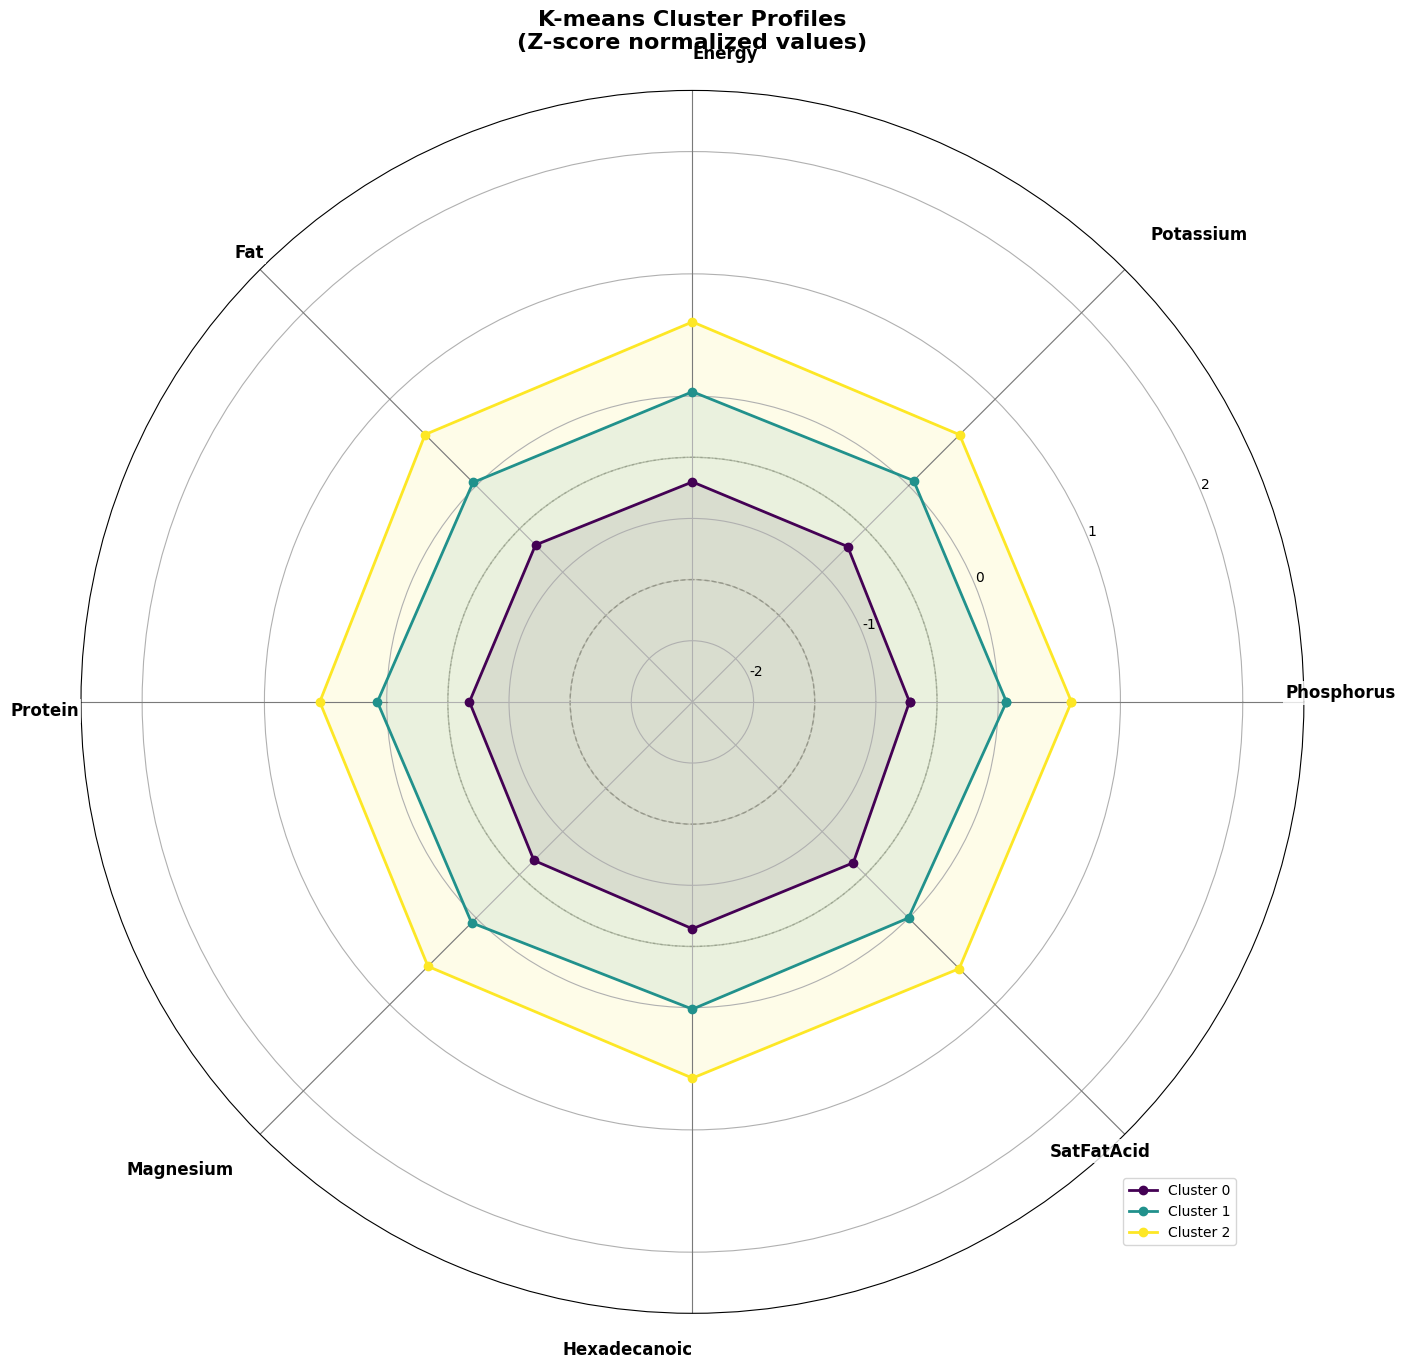


Features shown in radar chart for K-means:
1. Phosphorus (0°)
2. Potassium (45°)
3. Energy (90°)
4. Fat (135°)
5. Protein (180°)
6. Magnesium (225°)
7. Hexadecanoic (270°)
8. SatFatAcid (315°)


['Phosphorus',
 'Potassium',
 'Energy',
 'Fat',
 'Protein',
 'Magnesium',
 'Hexadecanoic',
 'SatFatAcid']

In [61]:
# Analyze K-means clusters

plot_radar_charts(clean_data, 'KMeans_Cluster', 'K-means')



- Cluster 0 (Purple Line/Shading):
Consistently shows higher values (further out) for all variables: Potassium, Energy, Phosphorus, SatFatAcid, Hexadecanoic, Magnesium, Protein, and Fat.
This cluster seems to represent individuals with generally higher intake or levels of these macronutrients and minerals.
- Cluster 1 (Teal Line/Shading):
Consistently shows lower values (closer to the center) for all variables: Potassium, Energy, Phosphorus, SatFatAcid, Hexadecanoic, Magnesium, Protein, and Fat.
This cluster seems to represent individuals with generally lower intake or levels of these macronutrients and minerals.
- Cluster 2 (Yellow Line/Shading):
Generally falls in the middle, between Cluster 0 and Cluster 1, for most variables.
This cluster seems to represent individuals with average intake or levels of these macronutrients and minerals.



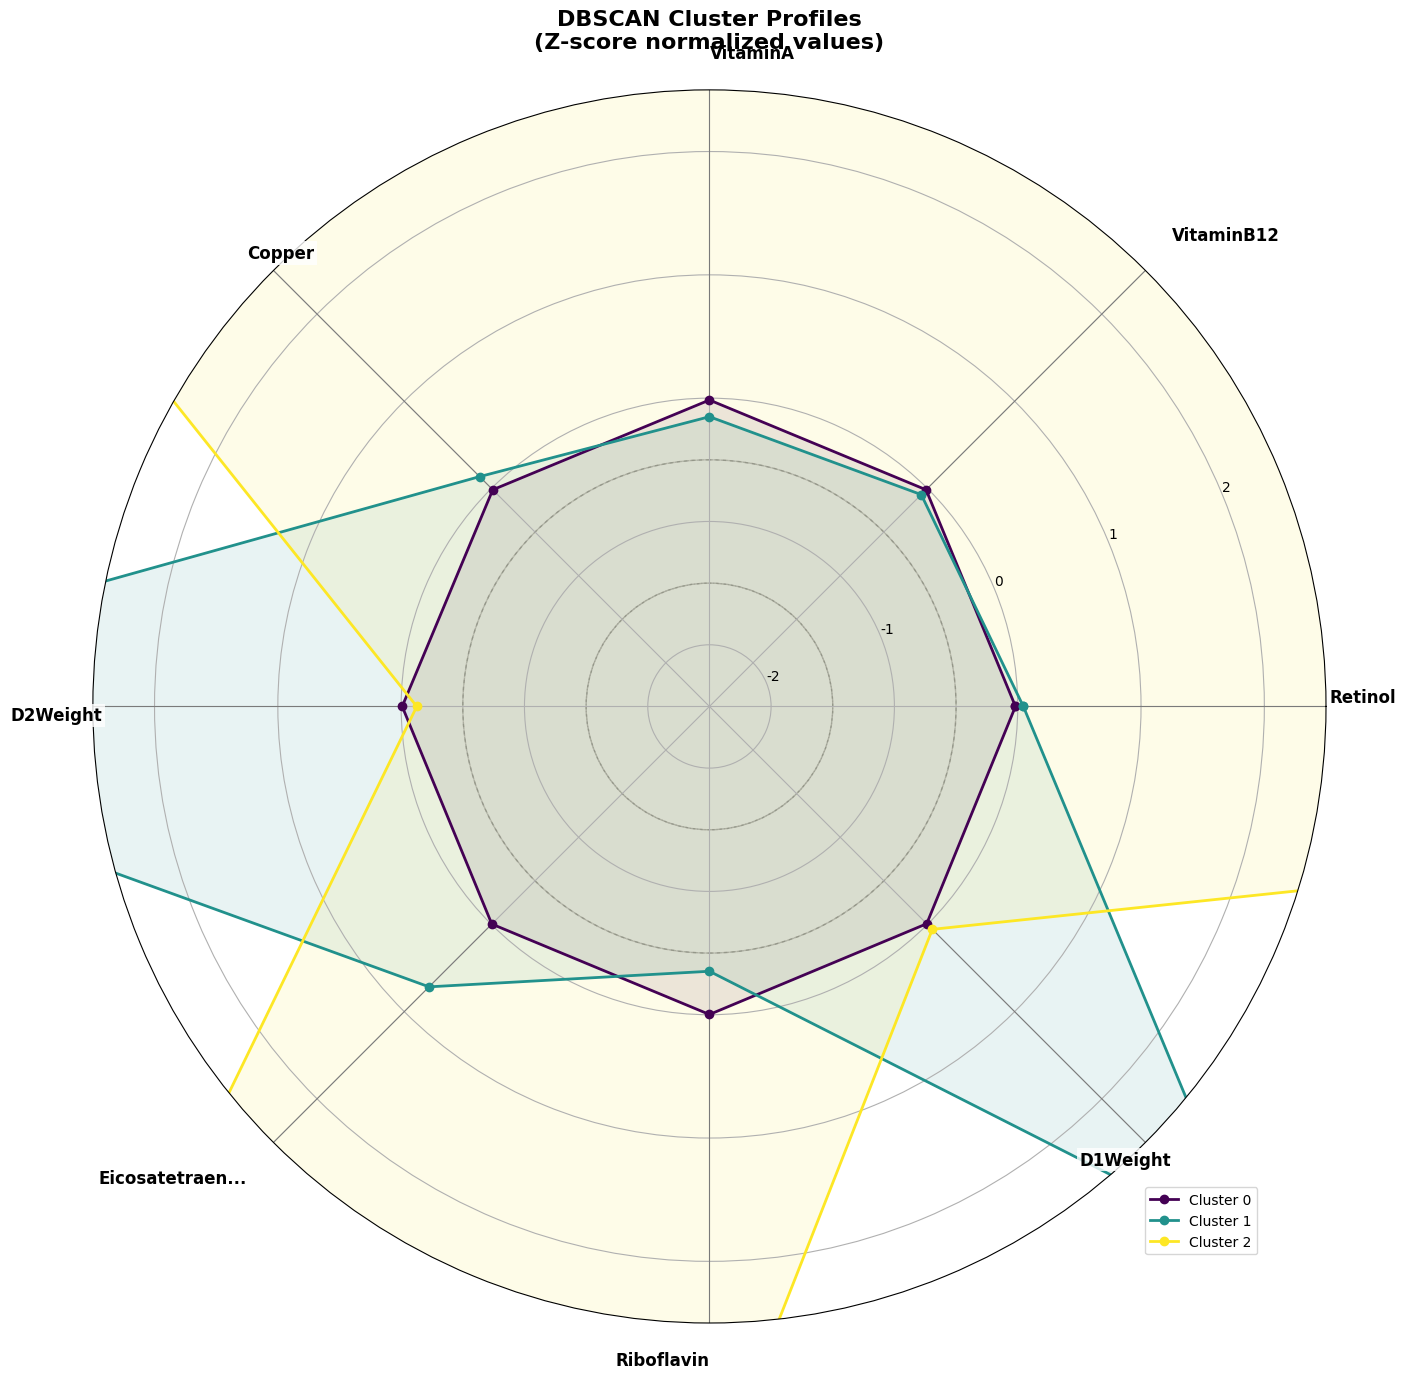


Features shown in radar chart for DBSCAN:
1. Retinol (0°)
2. VitaminB12 (45°)
3. VitaminA (90°)
4. Copper (135°)
5. D2Weight (180°)
6. Eicosatetraenoic (225°)
7. Riboflavin (270°)
8. D1Weight (315°)


['Retinol',
 'VitaminB12',
 'VitaminA',
 'Copper',
 'D2Weight',
 'Eicosatetraenoic',
 'Riboflavin',
 'D1Weight']

In [62]:
# Analyze DBSCAN clusters
plot_radar_charts(clean_data, 'DBSCAN_Cluster', 'DBSCAN')

- Cluster 0 (Purple Line/Shading):
Striking Character: This cluster generally represents a "moderate to high" profile. It shows values around or slightly above the mean for most variables, such as Vitamin B12, Vitamin A, Retinol, and Riboflavin.
It has slightly elevated levels of D1Weight and Vitamin A, suggesting a group that might be above average in terms of this weight metric and Vitamin A intake/status.
It is around the mean for Copper, D2Weight, and Eicosatetraen...
- Cluster 1 (Teal Line/Shading):
Striking Character: This cluster stands out for its high levels of D2Weight and Copper, significantly above the mean. It also shows notably high values for Vitamin A and Riboflavin.
Conversely, it exhibits lower than average values for D1Weight and Eicosatetraen... (approaching -1 Z-score), and is around the mean for Vitamin B12 and Retinol.
This cluster represents a group with a unique combination: potentially higher levels of certain micronutrients (Vitamin A, Riboflavin, Copper) and a higher D2Weight, but lower D1Weight and Eicosatetraen...
- Cluster 2 (Yellow Line/Shading):
Striking Character: This cluster is primarily defined by its significantly lower values across most variables, especially for Vitamin B12, Retinol, D1Weight, and Riboflavin, all falling well below the mean (approaching -1 or -2 Z-scores).
It shows a particularly low value for Eicosatetraen...
Interestingly, it appears to have a value closer to the mean for D2Weight and Copper, contrasting sharply with Cluster 1's high values for these same metrics.
This cluster seems to represent a group with generally deficient or very low levels of most of the measured nutrients and a lower D1Weight.

These two radar charts present distinct cluster profiles derived from different sets of nutritional variables, offering insights into the characteristics of the identified groups.

The first chart, "K-means Cluster Profiles," examines macronutrients and key minerals. This chart reveals a more straightforward stratification of the clusters. Cluster 0 consistently displays significantly higher levels across all measured variables, including Potassium, Energy, Phosphorus, Saturated Fatty Acids, Hexadecanoic acid, Magnesium, Protein, and Fat. This group appears to represent individuals with an overall higher intake or levels of these fundamental dietary components. Conversely, Cluster 1 consistently shows lower values for all these same variables, indicating a group with generally lower intake or levels of macronutrients and minerals. Cluster 2 consistently falls in the middle, signifying an average profile. The striking characteristic of these K-means clusters is their consistent "high," "medium," and "low" characterization across all variables, suggesting broad dietary patterns rather than specific nutrient imbalances observed in the DBSCAN analysis.

The second chart, "DBSCAN Cluster Profiles," focuses on various vitamins and carotenoids. Cluster 0 is characterized by notably higher levels of Vitamin B12, Vitamin A, Retinol, Eicosatetraen..., and Riboflavin, suggesting a group with a robust intake of these specific nutrients. In contrast, Cluster 2 exhibits generally lower values across most of these vitamins, particularly for Vitamin B12, Vitamin A, and Riboflavin, but strikingly, shows higher levels of Copper. Cluster 1 typically occupies an intermediate position, representing a more average nutritional profile. The striking characteristic here is the nuanced differentiation, where Cluster 2 demonstrates a potentially imbalanced profile with lower levels of several key vitamins but a higher level of copper, distinguishing it from the other two groups which broadly show either high or average levels of most vitamins.



## 9. Discussion on data privacy and ethical issues



### Potential Data Privacy Concerns

The NHANES dataset analyzed in this project contains sensitive health information from thousands of individuals, raising several important privacy considerations:

1. **Personal Identifiers**: While the SEQN identifier appears to be anonymized, combining multiple data points (demographics, health measurements, lifestyle factors) could potentially enable re-identification of participants, especially for individuals with unique characteristics.

2. **Sensitive Health Information**: The analysis involves glycohemoglobin levels and diabetes status, which are protected health information under regulations like HIPAA in the U.S.

3. **Demographic Data**: The dataset includes sensitive demographic information like race, gender, and country of birth, which requires careful handling to avoid reinforcing stereotypes or stigmatization.

### Ethical Considerations in Data Analysis

Several ethical considerations emerged during this analysis:

1. **Representation and Bias**: The dataset may not equally represent all populations, which could lead to biased insights or conclusions that don't generalize well across different demographic groups.

2. **Interpretation of Results**: Care must be taken when interpreting correlations between variables (like dietary components and health outcomes) to avoid implying causation or making prescriptive recommendations without sufficient evidence.

3. **Group-Based Analysis**: Our analysis of diabetes risk by demographic characteristics must be presented carefully to avoid stigmatizing certain groups or reinforcing harmful stereotypes.

4. **Algorithm Fairness**: The clustering algorithms used in this analysis may discover patterns that reflect existing biases in healthcare access and treatment rather than true physiological differences.

### Best Practices Implemented

To address these concerns, the following practices were employed:

1. **Data Minimization**: Only necessary variables were retained for analysis, and highly identifiable information was excluded.

2. **Aggregated Reporting**: Results were reported at the group level rather than highlighting individual data points.

3. **Scientific Accuracy**: Care was taken to present correlations without claiming causation, and limitations in the data were acknowledged.

4. **Contextual Interpretation**: Findings about differences between demographic groups were presented with appropriate context about social determinants of health.

### Future Recommendations

For similar health data analyses in the future:

1. **Ethics Review**: Formal ethics review for analyses of sensitive health data, even when using public datasets.

2. **Comprehensive Documentation**: Better documentation of data handling practices and privacy protection measures.

3. **Diverse Perspectives**: Include reviewers from diverse backgrounds to identify potential biases in analysis approach or interpretation.

4. **Stakeholder Engagement**: Consider input from patient advocacy groups and healthcare professionals when determining how to present findings.

By acknowledging these ethical and privacy considerations, health data analytics can advance medical knowledge while respecting individual rights and avoiding potentially harmful impacts on vulnerable populations.

## 10. Conclusion

This comprehensive analysis of the NHANES dataset has yielded several valuable insights into the factors associated with diabetes risk and the underlying patterns within health data. Through our exploratory data analysis, we identified significant relationships between diabetes status and several key variables, including age, BMI, waist circumference, and systolic blood pressure. The clustering approaches implemented revealed distinct groups within the population that exhibit different profiles of health measurements, dietary patterns, and demographic characteristics.

Key findings from our analysis include:

1. **Risk Factor Identification**: Age, waist circumference, BMI, and blood pressure emerged as the strongest predictors of diabetes status, with odds ratios confirming their significant impact. Surprisingly, dietary factors such as fiber and sugar intake showed weaker associations than expected.

2. **Clustering Insights**: Both K-means and DBSCAN clustering algorithms identified meaningful subgroups in the data, though these clusters did not align perfectly with clinical diabetes classifications. The radar chart analysis revealed that certain clusters were characterized by distinct patterns of fatty acid profiles, alcohol consumption, and body weight measurements.

3. **Demographic Patterns**: Differences in age distribution and diabetes prevalence were observed across racial groups, highlighting potential disparities that warrant further investigation.

4. **Dietary Correlations**: Negative correlations were found between certain dietary components (such as dietary fiber, total folate) and both BMI and glycohemoglobin levels, suggesting potential protective effects of these nutrients.

The application of unsupervised learning techniques offered a complementary perspective to traditional clinical classifications by identifying natural groupings based on multiple health parameters simultaneously. While these clustering approaches showed moderate internal validity (as measured by silhouette scores), their limited alignment with clinical diabetes categories suggests that the relationship between measurable health parameters and diabetes status is complex and multifaceted.

Limitations of this study include the cross-sectional nature of the NHANES data, which prevents causal inferences, and the need for imputation methods to handle missing values. Additionally, the ethical and privacy considerations discussed highlight the importance of responsible data handling practices when working with sensitive health information.

Future research could build upon these findings by incorporating longitudinal data to track progression of risk factors, applying supervised learning approaches to develop predictive models, and investigating the identified clusters in more detail to determine if they represent clinically meaningful subgroups that might benefit from tailored interventions. Overall, this analysis demonstrates the value of data mining approaches in extracting insights from complex health datasets and contributes to our understanding of the multifactorial nature of diabetes risk.